# SIT332 Task 5.2HD
## T2 2025 | Visal Dam, s223058093

Real-time Deepfake Audio Detection against Retrieval-based Voice Conversion (RVC)

In [1]:
#!pip install git+https://github.com/RVC-Project/Retrieval-based-Voice-Conversion

### Imports


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import librosa
import matplotlib.pyplot as plt

#from rvc.modules.vc.modules import VC
from dotenv import load_dotenv
from scipy.io import wavfile
from pathlib import Path

from pydub import AudioSegment
from pydub.utils import mediainfo
import time

C:\Users\lenovo\anaconda3_\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, matthews_corrcoef, auc, roc_curve, roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score

from mlxtend.evaluate import accuracy_score as extended_accuracy_score
from joblib import dump, load

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from joblib import dump, load
from scipy.stats import pearsonr

In [9]:
# Configs

In [3]:
pd.set_option("display.max_columns", None)

In [2]:
np.random.seed(0) #ensure same results

### Functions

#### RVC (Adversary)

In [23]:
#def rvc_audio(model_path, input_speech_path, output_speech_path):
      #vc = VC()
      #vc.get_vc(Path(model_path))
      #tgt_sr, audio_opt, times, _ = vc.vc_inference(1, Path(input_speech_path))
      #wavfile.write(Path(output_speech_path), tgt_sr, audio_opt)

#### Utility

In [35]:
def get_scaled(df, scaler_obj):
    original_features = df.drop(columns=["LABEL"])
    original_labels = df["LABEL"]
    scaled_features = pd.DataFrame(scaler_obj.fit_transform(original_features), columns=original_features.columns)

    scaled_dataset_balance = pd.concat([scaled_features, original_labels], axis=1)
    plot_feature_correlation(scaled_dataset_balance, f"PCA Feature Correlation using ({scaler_obj})")

    return scaled_dataset_balance

In [36]:
def printStatsGS(clf, params, X_test, y_test):
    print("Parameters used: ", params)
    print("==========================")
    print("[^_^] Best estimator: ", clf.best_estimator_)
    print("Best cross-validated score: ", clf.best_score_)
    print("Best parameters: ", clf.best_params_)
    print("==========================")
    print("This estimator's accuracy score: ", clf.score(X_test, y_test))

In [37]:
def create_dataset(frame_length_sec):    
    df_list = []
    
    # Real
    for dirpath, dirnames, filenames in os.walk(r"C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real"):
        for f in filenames:
            if f.lower().endswith(".wav"):  # only WAV files
                full_path = os.path.join(dirpath, f)
                df_list.append(get_features_row(full_path, "REAL", frame_length_sec))
    # Fake 
    for dirpath, dirnames, filenames in os.walk(r"E:\332\fake"):
        for f in filenames:
            if f.lower().endswith(".wav"):  # only WAV files
                full_path = os.path.join(dirpath, f)
                df_list.append(get_features_row(full_path, "FAKE", frame_length_sec))
    
    # Create dataset
    dataset = pd.concat(df_list, ignore_index=True)
    return dataset

In [38]:
def balance_df(dataset):
    df_majority = dataset[dataset["LABEL"] == "FAKE"]
    df_minority = dataset[dataset["LABEL"] == "REAL"]
    
    # Downsample (guaranteed)
    df_majority_down = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),
        random_state=42
    )
    
    dataset_balance = pd.concat([df_majority_down, df_minority]).reset_index(drop=True)
    return dataset_balance

In [39]:
def run_while_i_sleep(clf, params, X_train, y_train, X_test, y_test):
    try:
        best_clf = do_kfold_cv(10, clf, params, X_train, y_train, X_test, y_test)
        dump(best_clf, f"{clf.__class__.__name__}.joblib")
        get_metrics(best_clf, X_test, y_test)
    except Exception as e:
        print(f"[!] Error for {clf.__class__.__name__}: {e}. Skipping...")

#### Hyperparameterization

In [40]:
def do_kfold_cv(folds, clf, params, X_train, y_train, X_test, y_test):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    clf_cv = GridSearchCV(estimator=clf, param_grid=params, cv=kf, scoring='f1', verbose=1, return_train_score=True, n_jobs=-1) # concurrent
    clf_cv.fit(X_train, y_train)
    printStatsGS(clf_cv, params, X_test, y_test)
    return clf_cv.best_estimator_

#### Metrics

In [59]:
def get_metrics(clf, X_test, y_test):
    print(f"<===== Metrics for {clf.__class__.__name__} =====>")
    start = time.time()
    y_pred = clf.predict(X_test)
    end = time.time()

    # Average time per 1 sec block
    print(f"Average inference time (1s): {(end - start)/len(X_test) * 1000:.3f} ms")

    # overview
    print(classification_report(y_test, y_pred, digits=3))
          
    # Accuracy score
    print(f"[ACC] Accuracy: {accuracy_score(y_test, y_pred):.3f}")

    # Accuracy score per class
    for c in clf.classes_:
        print(f"-> [{c}]: {extended_accuracy_score(y_test, y_pred, method='binary', pos_label=c):.3f}")

    # MCC
    print(f"[MCC] Matthews Correlation Coefficient (MCC): {matthews_corrcoef(y_test, y_pred):.3f}")

    ## Plots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=ax[0])

    # ROC Curve
    plot_roc_curve_manual(clf, X_test, y_test, clf.__class__.__name__, ax[1])

    # Get importance
    try:
        importance = clf.feature_importances_
        
        feature_importance_df = pd.DataFrame({'Feature': X.columns,'Importance': importance}).sort_values(by='Importance', ascending=False)
        
        plt.figure(figsize=(12,6))
        plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
        plt.xlabel("Importance")
        plt.title(f"Feature Importance for {clf.__class__.__name__}")
        plt.gca().invert_yaxis() 
        plt.show()
    except:
        print(f"[!] Feature importance cannot be applied to {clf.__class__.__name__}. Skipping...")

In [42]:
#adapted from Simon, D (2021). Data Challenge - Machine Learning for anomaly detection [Python Code]. Github. https://github.com/simondelarue/Data-Challenge_Anomaly-Detection 
def plot_roc_curve_manual(estimator, X_test, y_test, name, ax):
    ''' Plot ROC Curve based on model predictions, with focus on AUC metric 
        Parameters
        -----------
            y : y_preday of ground truth values to predict
            y_pred : Array of predictions (i.e output of model)
            model_name : String for plot title
            ax : Location of plot in the figure (ex. ax[0])
        
        Ouput
        -----------
            ax : Return axe to fill figure '''
    predicted_y_prob = estimator.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, predicted_y_prob[:,1])
    ax.plot(fpr, tpr, label=f'AUC {name} : {roc_auc_score(y_test, predicted_y_prob[:,1]):.3f}')
    ax.plot([0, 1],[0, 1], ls='--', color='black')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {name}', fontweight='bold')
    ax.legend(prop={'size': 11});
    return ax

#### Plotting

In [60]:
def plot_feature_correlation(df, title):
    pca = PCA(n_components=2)
    
    normal_features = df[df['LABEL'] == "REAL"]
    normal_features = normal_features.drop(columns='LABEL')
    fraud_features = df[df['LABEL'] == "FAKE"]
    fraud_features = fraud_features.drop(columns='LABEL')

    normal_pca = pca.fit_transform(normal_features)
    fraud_pca = pca.transform(fraud_features)

    fig, axes = plt.subplots(1, 3, figsize=(16,6), dpi=100)
    
    # REAL only
    axes[0].scatter(normal_pca[:, 0], normal_pca[:, 1], c='g', alpha=0.6, s=75, marker=".", label='REAL')
    axes[0].set_title("REAL only")
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")
    axes[0].legend()
    #axes[0].set_ylim(-3000, 1500)  
    #axes[0].set_xlim(-5000, 15000) 
    
    # Plot FAKE only
    axes[1].scatter(fraud_pca[:, 0], fraud_pca[:, 1], c='r', alpha=0.6, s=75, marker=".", label='FAKE')
    axes[1].set_title("FAKE only")
    axes[1].legend()
    axes[1].set_xlabel("PCA Component 1")
    axes[1].set_ylabel("PCA Component 2")
    axes[1].legend()
    #axes[1].set_ylim(-3000, 1500)  
    #axes[1].set_xlim(-5000, 15000) 

    # Plot both combined
    axes[2].scatter(normal_pca[:, 0], normal_pca[:, 1], c='g', alpha=0.6, s=75, marker=".", label='REAL')
    axes[2].scatter(fraud_pca[:, 0], fraud_pca[:, 1], c='r', alpha=0.3, s=75, marker=".", label='FAKE')
    axes[2].set_title(title)
    axes[2].set_xlabel("PCA Component 1")
    axes[2].set_ylabel("PCA Component 2")
    axes[2].legend()
    #axes[2].set_ylim(-3000, 1500)  
    #axes[2].set_xlim(-5000, 15000) 
    fig.suptitle(title, fontsize=16, y=0.95)
    
    plt.tight_layout()
    plt.show()

#### Feature Extraction

In [44]:
def get_features_row(input_audio_path, label, frame_length_sec):
    print(f"<==== Current audio: {os.path.basename(input_audio_path)} [{label}] ====>")
    y, sr = librosa.load(input_audio_path, sr=None)
    print("sr: ", sr)

    block_length = sr  # 1 second block
    overlap_constant = 0.6354 # Paper's overlapping value
    hop = int(sr * overlap_constant )
    duration = librosa.get_duration(y=y, sr=sr)
    print(f"Audio length: {duration:.2f} seconds")

    # Number of blocks
    num_blocks = int((len(y) - block_length) / hop) + 1
    features = []
    processing_times = []

    # Convert frame length to samples
    frame_length_samples = int(frame_length_sec * sr) if frame_length_sec != 1 else sr + 1 # whole block as frame!
    hop_frame = frame_length_samples # no overlap between frames within block if 1 as whole block is frame

    for i in range(num_blocks): # per 1s blocks
        begin = time.time()
        start = i * hop
        end = start + block_length
        block = y[start:end]

        num_frames = int((len(block) - frame_length_samples) / hop_frame) + 1
        
        for j in range(num_frames):
            start_frame = j * hop_frame
            end_frame = start_frame + frame_length_samples
            frame = block[start_frame:end_frame]
            n_fft=frame_length_samples+1
            hop_length=frame_length_samples+1

            # Compute features per frame (no overlap)
            chroma = librosa.feature.chroma_stft(y=frame, n_fft=n_fft, hop_length=hop_length).flatten()
            rms = librosa.feature.rms(y=frame, hop_length=hop_length).flatten()
            spec_cent = librosa.feature.spectral_centroid(y=frame, n_fft=n_fft, hop_length=hop_length).flatten()
            spec_bw = librosa.feature.spectral_bandwidth(y=frame, n_fft=n_fft, hop_length=hop_length).flatten()
            rolloff = librosa.feature.spectral_rolloff(y=frame, n_fft=n_fft, hop_length=hop_length).flatten()
            zcr = librosa.feature.zero_crossing_rate(y=frame, frame_length=n_fft, hop_length=hop_length).flatten()
            mfcc = librosa.feature.mfcc(y=frame, n_mfcc=20, n_fft=n_fft, hop_length=hop_length).flatten()

            features.append(np.concatenate([chroma, rms, spec_cent, spec_bw, rolloff, zcr, mfcc]))
            
        processing_times.append(time.time() - begin)
        
    df = pd.DataFrame(features, columns=col_names)
    df["LABEL"] = label
    avg_time = np.mean(processing_times)
    print(f"==> {os.path.basename(input_audio_path)}: Success! Average processing time (1 second blocks): {avg_time:.3f}s ({avg_time*1000:.3f}ms)")
    return df

In [45]:
col_names = [
    "chroma_stft_1","chroma_stft_2","chroma_stft_3","chroma_stft_4","chroma_stft_5","chroma_stft_6","chroma_stft_7","chroma_stft_8","chroma_stft_9","chroma_stft_10","chroma_stft_11","chroma_stft_12",
    "rms",
    "spec_cent",
    "spec_bw",
    "rolloff",
    "zcr",
    "mfcc_1","mfcc_2","mfcc_3","mfcc_4","mfcc_5","mfcc_6","mfcc_7","mfcc_8","mfcc_9","mfcc_10","mfcc_11","mfcc_12","mfcc_13","mfcc_14","mfcc_15","mfcc_16","mfcc_17","mfcc_18","mfcc_19","mfcc_20",
]

### Data Analysis

#### Paper's Dataset

In [45]:
dataset_paper = pd.read_csv("DATASET-balanced.csv")

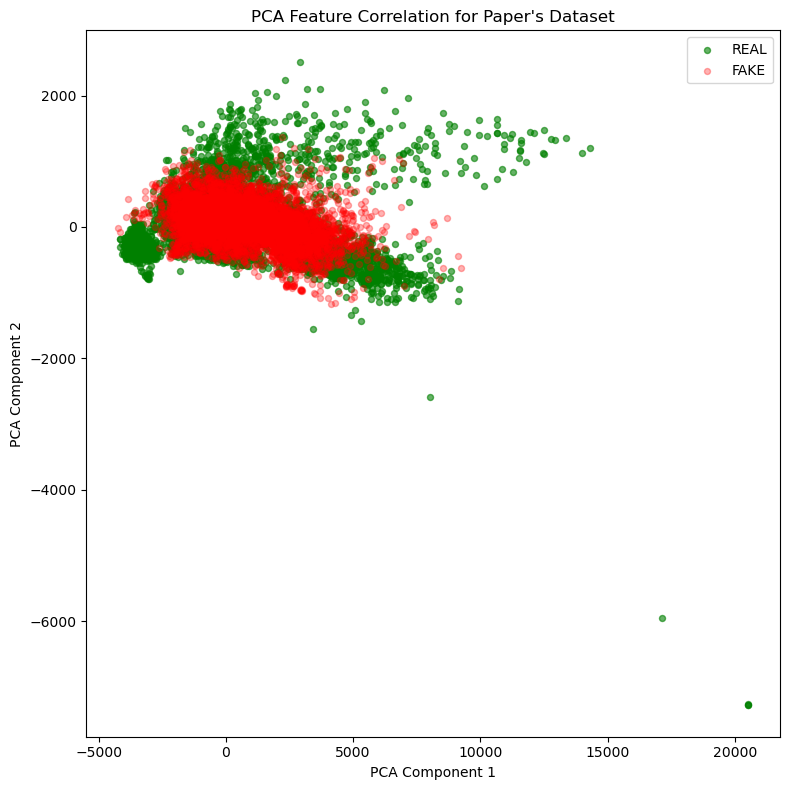

In [135]:
plot_feature_correlation(dataset_paper, "PCA Feature Correlation for Paper's Dataset")

#### Raw

In [46]:
dataset_balance = pd.read_csv("dataset_full_balanced.csv")

if "Unnamed: 0" in dataset_balance.columns:
    dataset_balance = dataset_balance.drop(columns=["Unnamed: 0"])

In [47]:
dataset_balance

chroma_stft_1  chroma_stft_2  chroma_stft_3  chroma_stft_4  \
0           0.996099       1.000000       0.668243       0.627178   
1           0.289238       0.464180       0.844005       0.736179   
2           0.530231       0.205782       0.225617       0.154427   
3           0.794635       0.645277       0.708530       0.659428   
4           0.334195       0.196815       0.308572       0.355203   
...              ...            ...            ...            ...   
14133       0.276514       0.136797       0.152557       0.210157   
14134       0.054321       0.209313       0.182758       0.084422   
14135       0.650096       0.252178       0.106281       0.204532   
14136       0.553911       0.898567       0.697684       0.489156   
14137       0.654675       0.913179       0.856544       1.000000   

       chroma_stft_5  chroma_stft_6  chroma_stft_7  chroma_stft_8  \
0           0.795229       0.617621       0.451576       0.422399   
1           1.000000       0.759958       0.335239       0.305285   
2           0.127415       0.205170       0.129216       0.077442   
3           0.943173       1.000000       0.564239       0.294279   
4           0.376575       1.000000       0.213205       0.059496   
...              ...            ...            ...            ...   
14133       0.353156       1.000000       0.763184       0.222761   
14134       0.377679       0.394536       1.000000       0.608275   
14135       0.326948       1.000000       0.685679       0.440514   
14136       0.328029       0.182613       0.242597       0.284316   
14137       0.917594       0.776825       0.622550       0.611285   

       chroma_stft_9  chroma_stft_10  chroma_stft_11  chroma_stft_12  \
0           0.284201        0.279558        0.350969        0.470083   
1           0.217228        0.217246        0.364880        0.275293   
2           0.102019        0.195575        0.393611        1.000000   
3           0.169671        0.236229        0.276852        0.672393   
4           0.062110        0.074700        0.050840        0.138631   
...              ...             ...             ...             ...   
14133       0.227066        0.259242        0.074845        0.183981   
14134       0.184633        0.094140        0.412545        0.199893   
14135       0.356607        0.232507        0.240480        0.417433   
14136       0.456755        0.868415        1.000000        0.609909   
14137       0.781365        0.746845        0.666827        0.731242   

            rms    spec_cent      spec_bw      rolloff       zcr      mfcc_1  \
0      0.004535  1967.384461  2002.004625  4217.062500  0.045525  -64.129990   
1      0.003522  1223.038082  1695.877987  2147.670000  0.037175  -95.422035   
2      0.037191  2386.988705  1769.745662  4207.140000  0.074350   19.986828   
3      0.053486  2691.214769  1733.058740  4604.040000  0.110300  153.797470   
4      0.003598  2486.435346  2190.333849  4851.000000  0.017550 -130.881699   
...         ...          ...          ...          ...       ...         ...   
14133  0.003244  1369.725801  1794.091769  2773.374223  0.027504  -19.851208   
14134  0.028860  1652.312180  1862.252681  3512.340710  0.042991    9.150717   
14135  0.001412  2368.305951  1944.662355  4365.302027  0.072491  -16.617069   
14136  0.003133  2004.107763  1957.796356  4106.313773  0.062242   -4.405774   
14137  0.001310  3372.456433  2547.811163  6497.705319  0.128135 -162.393036   

           mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6     mfcc_7  \
0      101.126785 -42.528553  53.344894   6.179201  43.580223  19.936642   
1      154.242950 -16.753067   9.848974  -1.355270  22.449993  -1.950959   
2      104.482330 -65.392570  87.740891 -21.897411  10.632298   1.278986   
3       71.500626 -85.388184  49.422577 -13.334240  29.308296   0.234914   
4       80.647293 -14.090109  91.122452  -4.213405  12.044609 -33.589359   
...           ...        ...        ...        ...        ...      

#### Feature Distribution

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


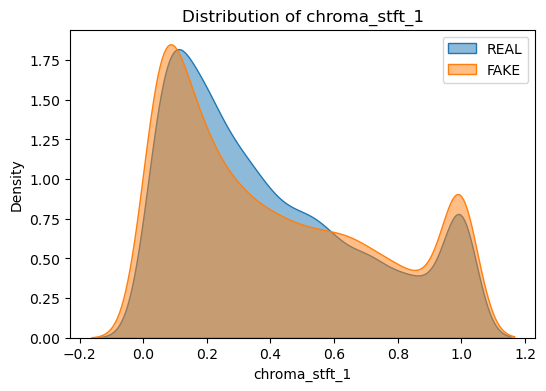

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


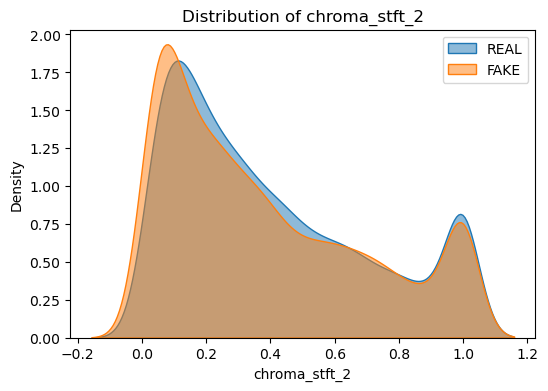

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


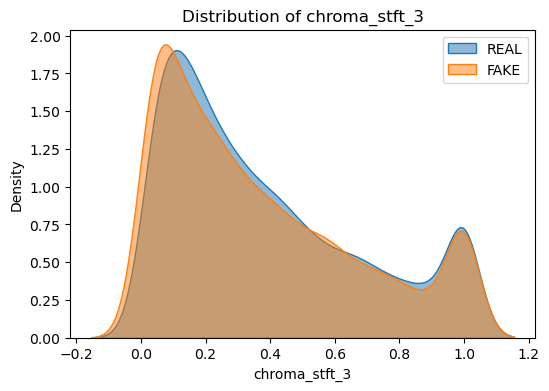

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


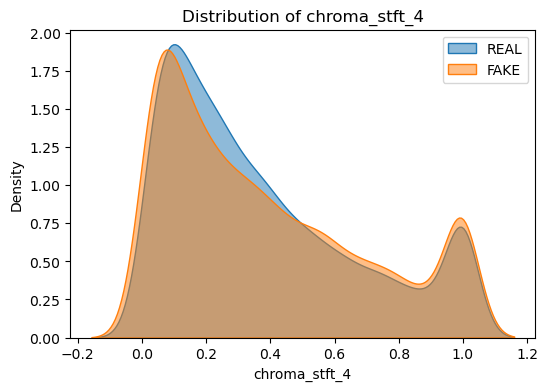

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


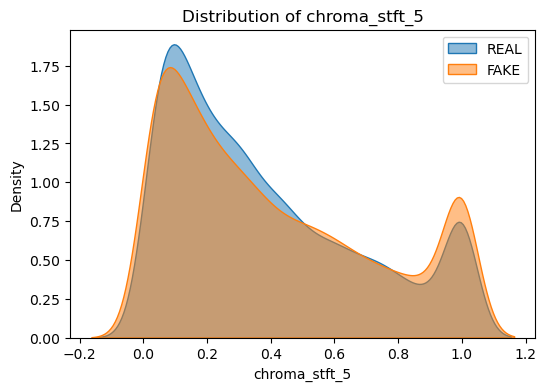

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


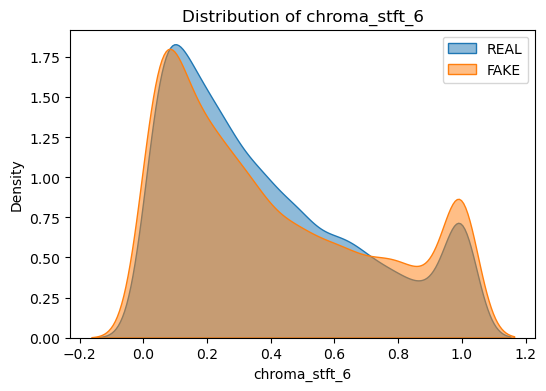

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


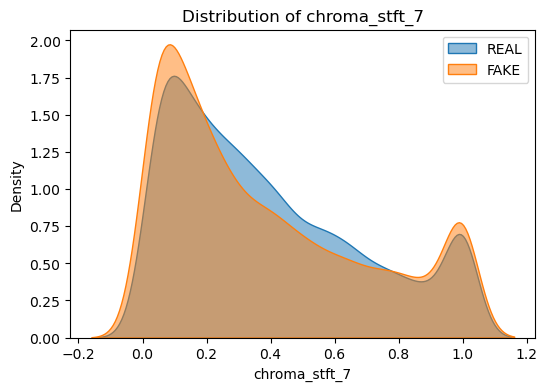

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


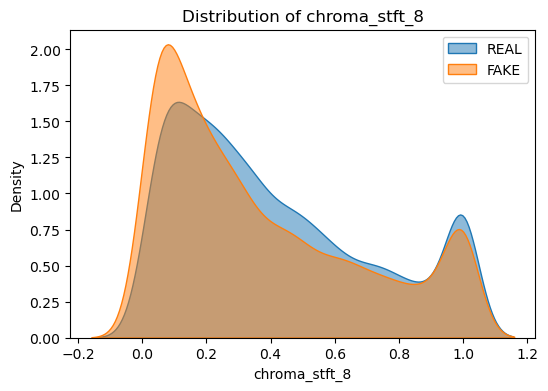

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


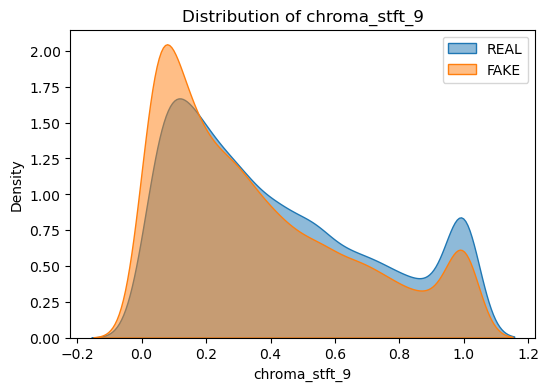

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


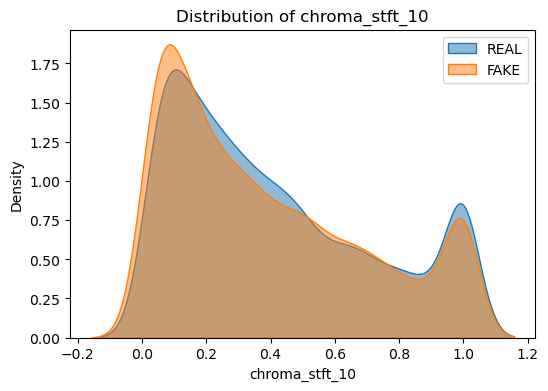

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


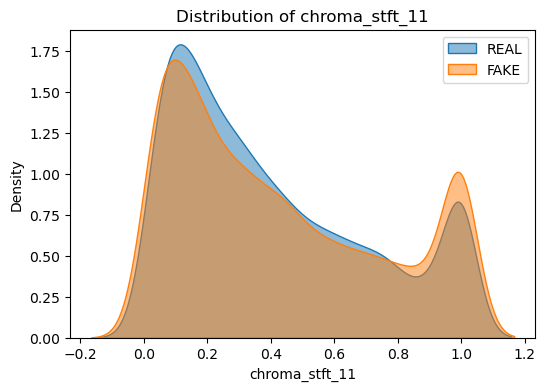

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


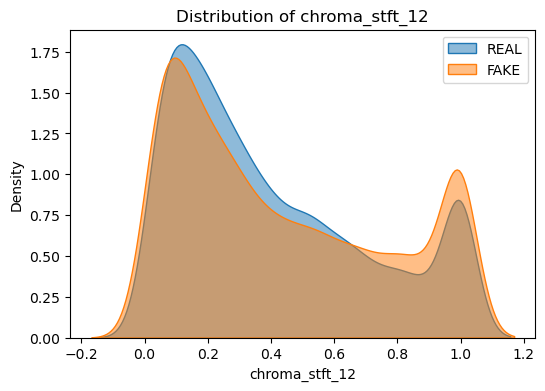

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


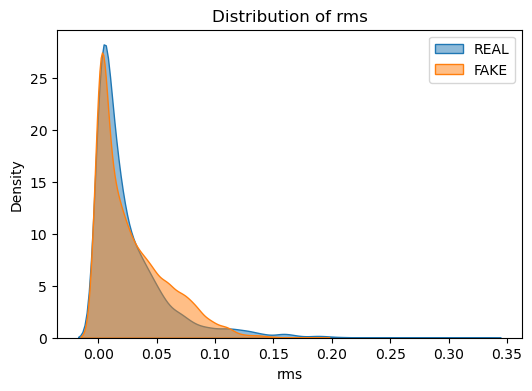

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


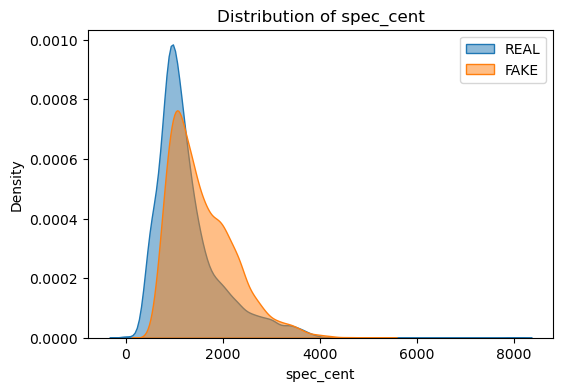

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


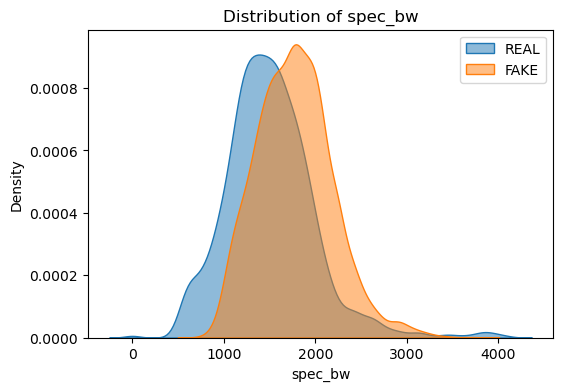

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


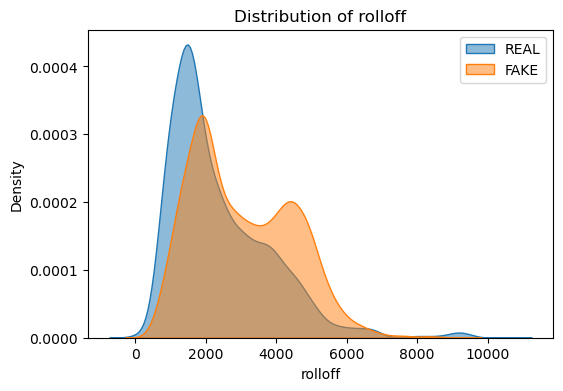

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


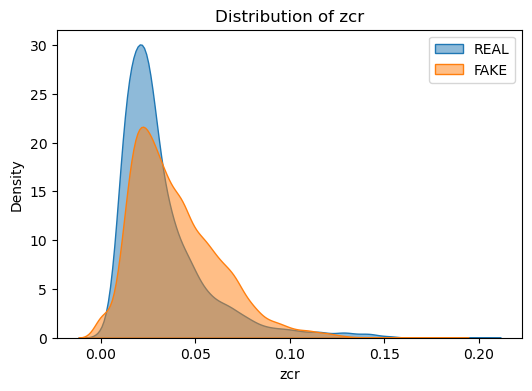

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


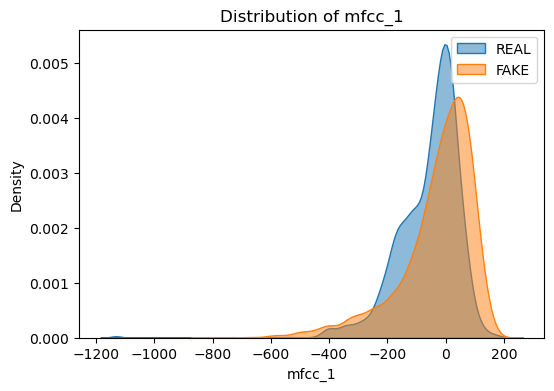

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


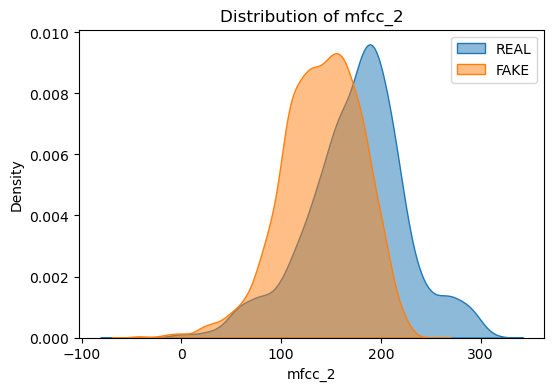

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


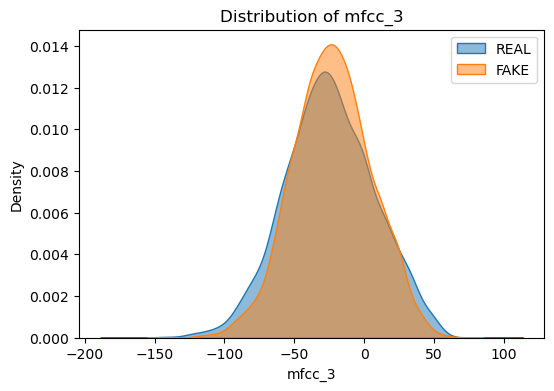

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


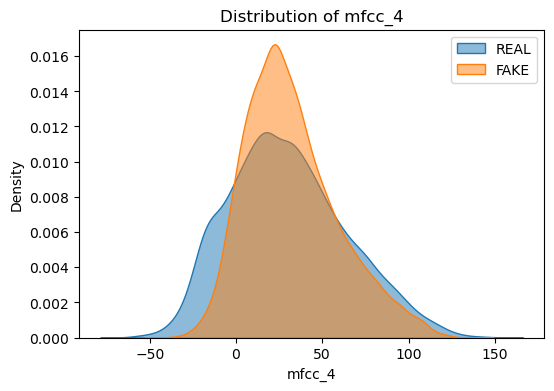

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


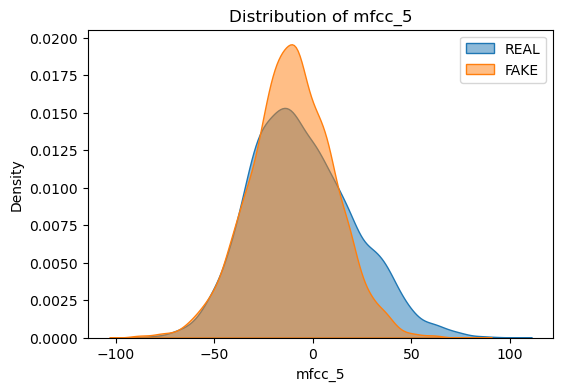

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


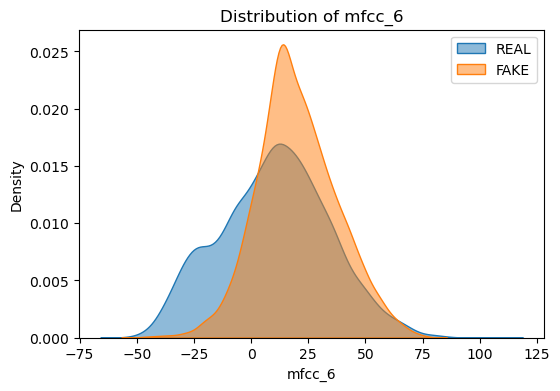

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


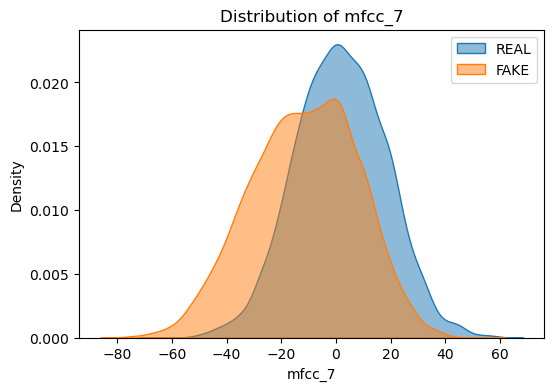

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


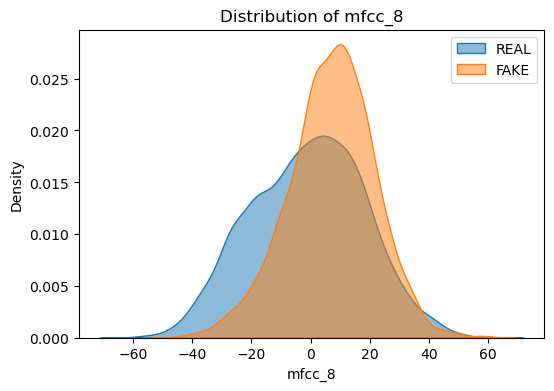

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


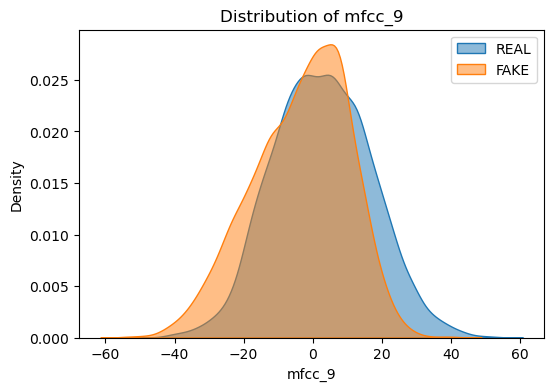

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


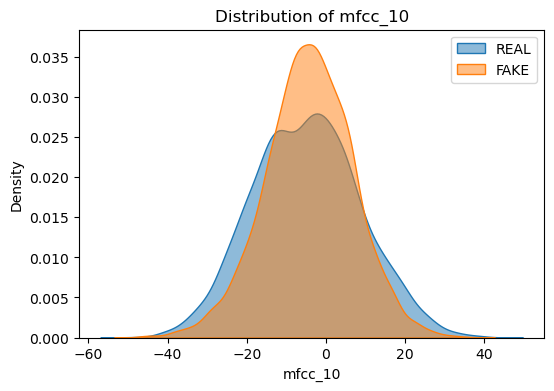

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


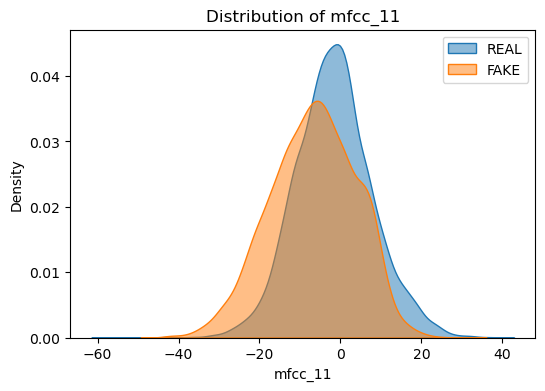

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


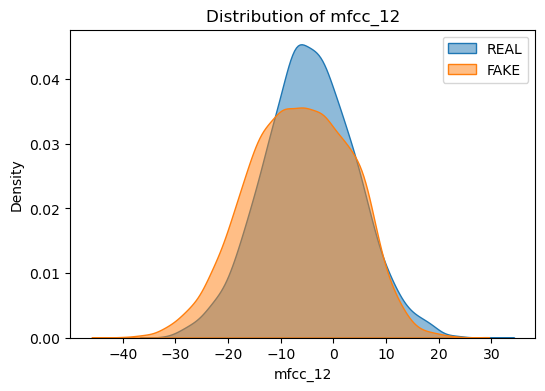

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


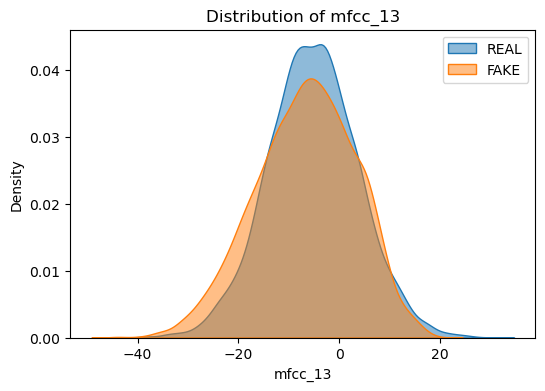

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


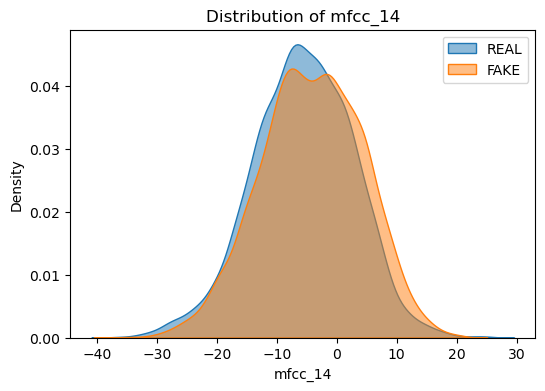

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


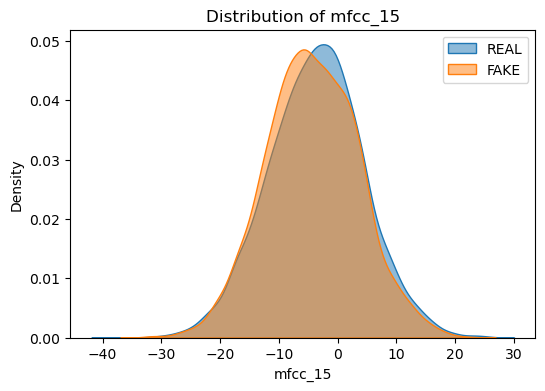

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


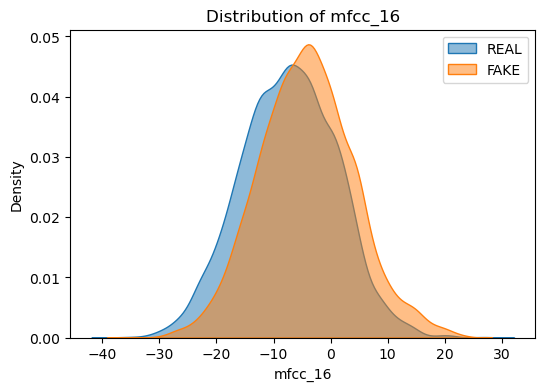

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


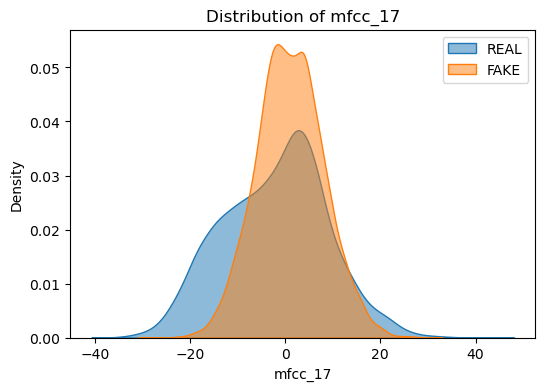

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


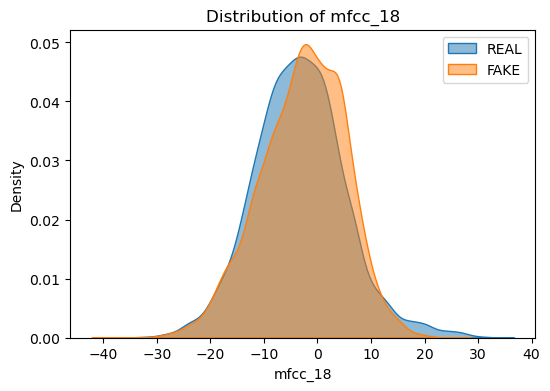

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


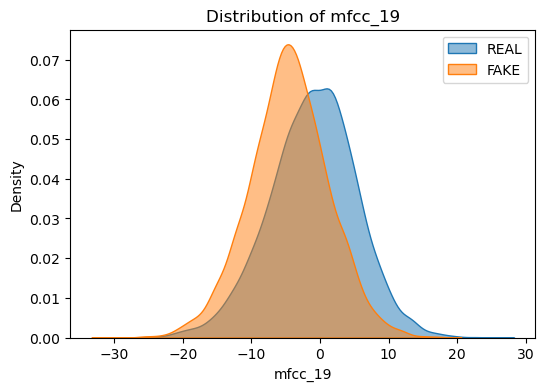

C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lenovo\anaconda3_\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


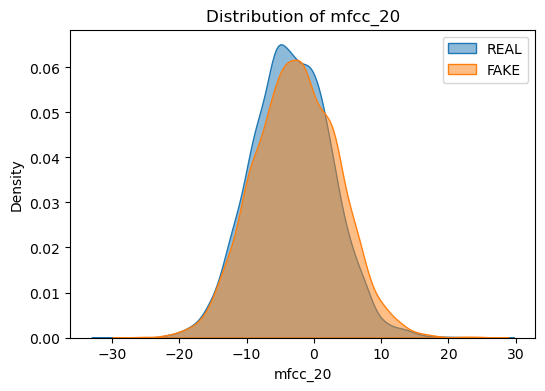

In [48]:
for feat in col_names:
    plt.figure(figsize=(6,4))
    sns.kdeplot(dataset_balance[dataset_balance['LABEL']=="REAL"][feat], label='REAL', fill=True, alpha=0.5)
    sns.kdeplot(dataset_balance[dataset_balance['LABEL']=="FAKE"][feat], label='FAKE', fill=True, alpha=0.5)
    plt.title(f'Distribution of {feat}')
    plt.xlabel(feat)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

#### Feature Correlation (PCA)

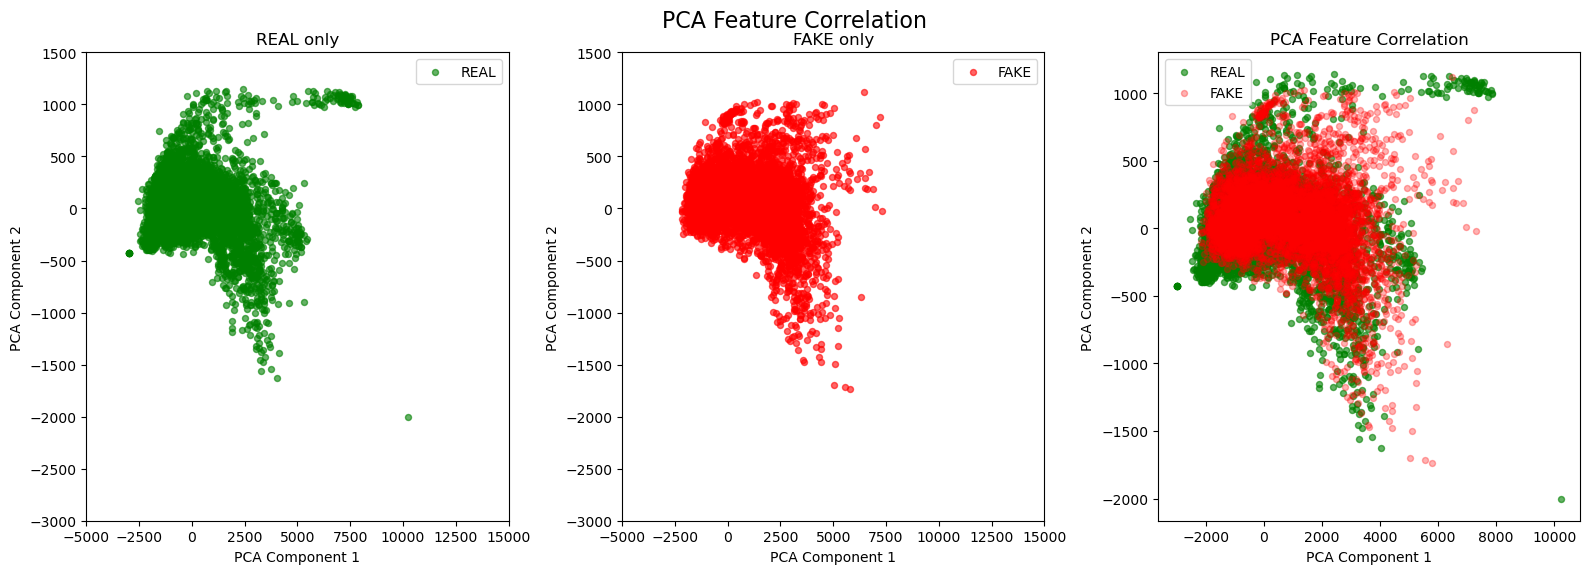

In [51]:
plot_feature_correlation(dataset_balance, "PCA Feature Correlation")

#### Feature Correlation when scaled

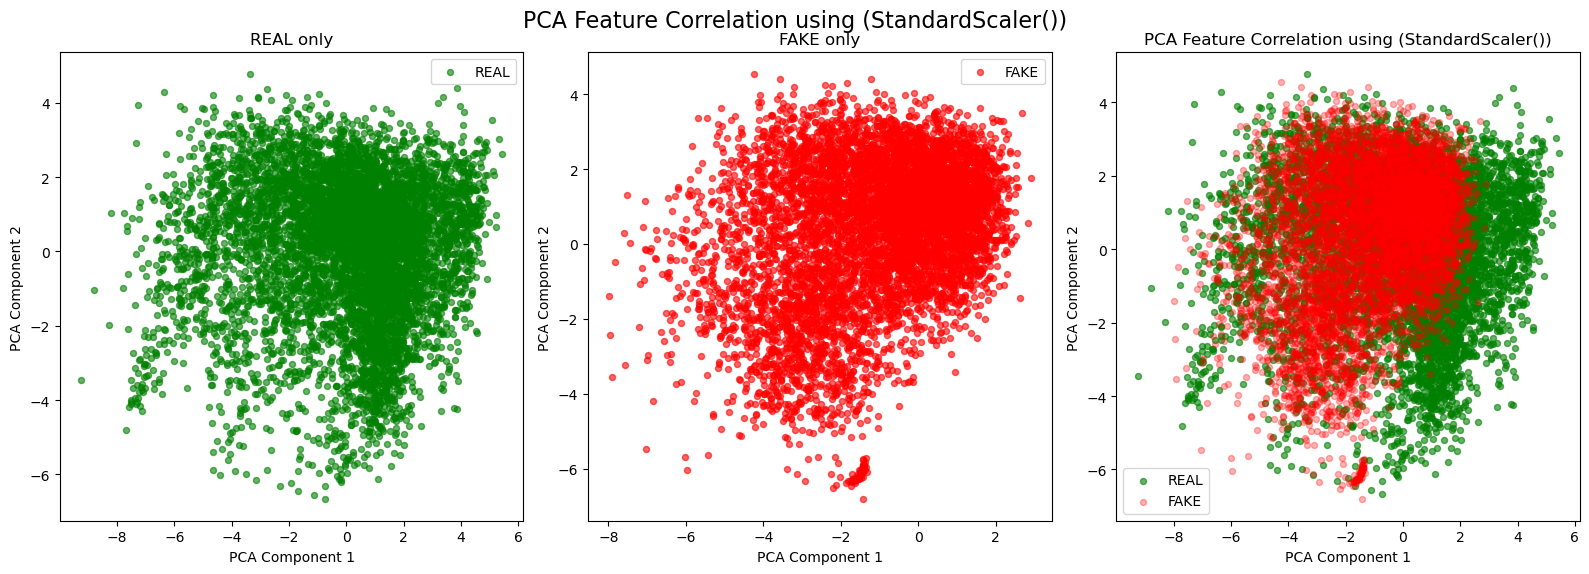

In [61]:
scaled_df = get_scaled(dataset_balance, StandardScaler())

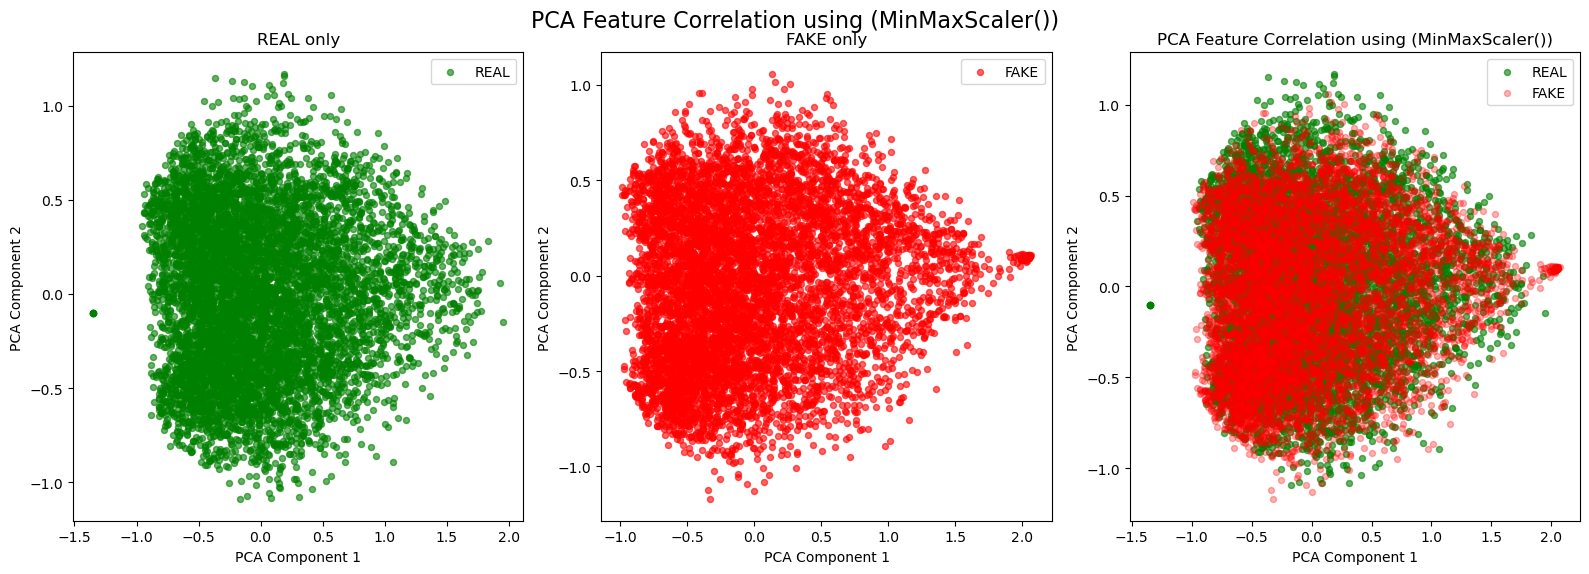

In [62]:
scaled_df = get_scaled(dataset_balance, MinMaxScaler()) # bad!

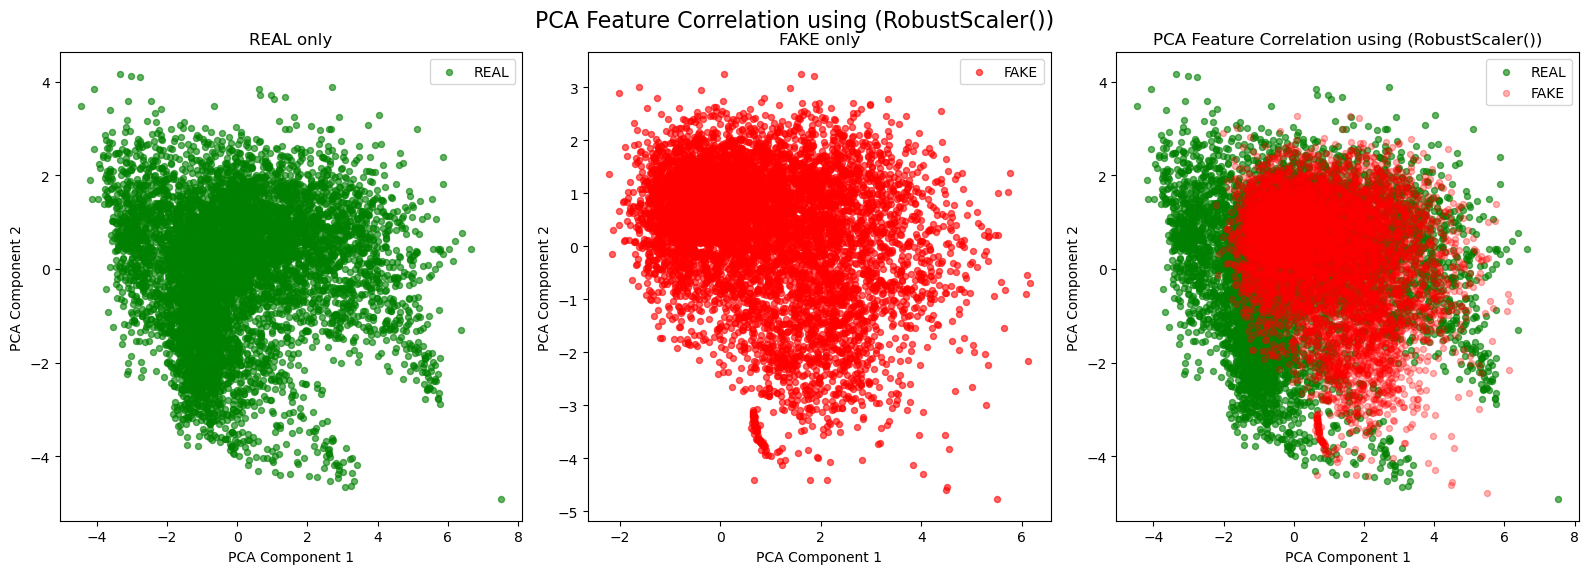

In [63]:
scaled_df = get_scaled(dataset_balance, RobustScaler())

#### Pearson's Correlation Coefficient

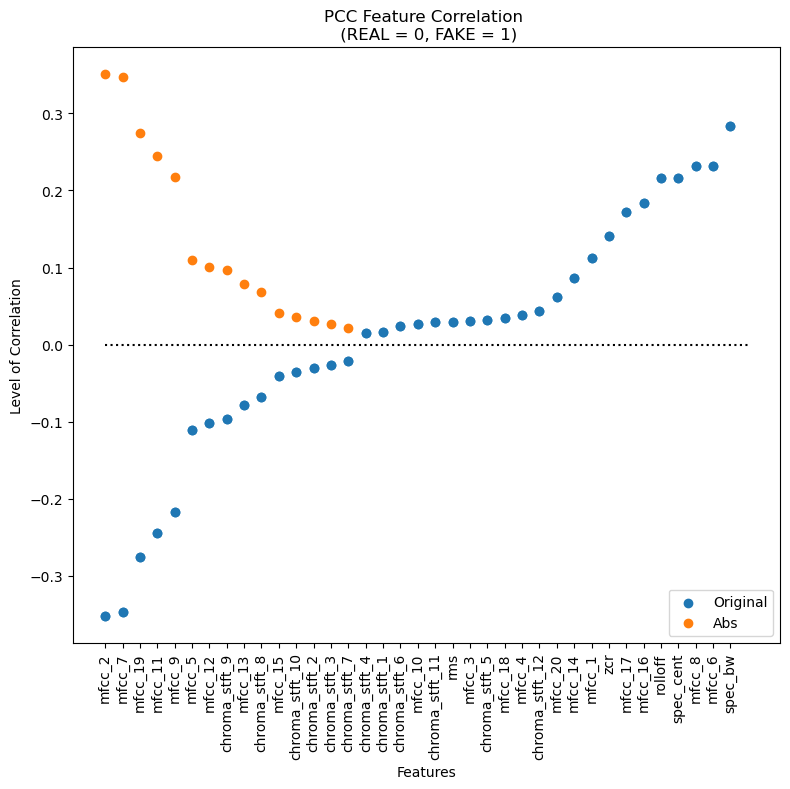

In [64]:
fig, ax = plt.subplots(figsize=(8, 8))
pcc_1d_corr = dataset_balance[col_names].corrwith(dataset_balance["LABEL"].map({'REAL': 0, 'FAKE': 1}), method='pearson').sort_values(ascending=True)
pcc_1d_corr.plot(kind='line', marker='o',linestyle='None') 

# get magnitude of negatives
pcc_mapped = pcc_1d_corr[pcc_1d_corr < 0].abs().sort_values(ascending=False)
ax.scatter(range(len(pcc_1d_corr)), pcc_1d_corr, marker='o', label='Original')

ax.scatter(
    [pcc_1d_corr.index.get_loc(i) for i in pcc_mapped.index],  
    pcc_mapped.values, marker='o', label="Abs"
)

plt.title("PCC Feature Correlation \n (REAL = 0, FAKE = 1)")
plt.ylabel("Level of Correlation")
plt.xlabel("Features")
plt.xticks(ticks=range(len(pcc_1d_corr)), labels=pcc_1d_corr .index, rotation=90)
plt.hlines(y=0, xmin=0, xmax=len(pcc_1d_corr), color='black', linestyle=':')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

fig.savefig("pcc.pdf", format='pdf')

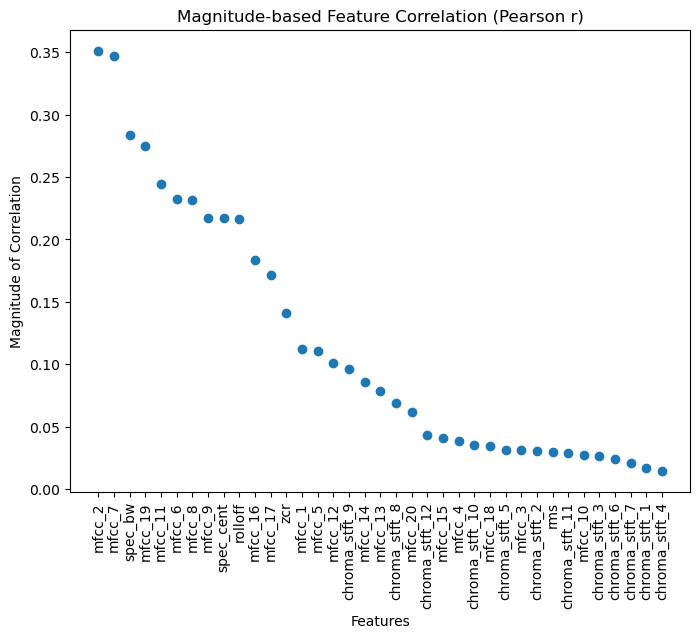

In [65]:
pcc_1d_corr = dataset_balance[col_names].corrwith(dataset_balance["LABEL"].map({'REAL': 0, 'FAKE': 1}), method='pearson').abs().sort_values(ascending=False)
pcc_1d_corr.plot(kind='line', marker='o',linestyle='None', figsize=(8,6)) 
plt.title("Magnitude-based Feature Correlation (Pearson r)")
plt.ylabel("Magnitude of Correlation")
plt.xlabel("Features")
plt.xticks(ticks=range(len(pcc_1d_corr)), labels=pcc_1d_corr .index, rotation=90)
plt.show()

### ML

In [69]:
#data = scaled_df
data = dataset_balance

In [70]:
X = data.drop(columns='LABEL')
y = (data['LABEL'] == 'FAKE').astype(int)  # 0 -> REAL, 1 -> FAKE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
X_s = scaled_df.drop(columns='LABEL')
y_s = (scaled_df['LABEL'] == 'FAKE').astype(int)  # 0 -> REAL, 1 -> FAKE

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.3, random_state=42)

#### XGBoost (Best in paper)

In [46]:
xgb_params = {
    "n_estimators": [100, 300, 330, 500, 800],
    "eta": [0.01, 0.05, 0.1, 0.2],
}

In [47]:
clf_xgb = do_kfold_cv(10, xgb.XGBClassifier(), xgb_params, X_train, y_train, X_test, y_test)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Parameters used:  {'n_estimators': [100, 300, 330, 500, 800], 'eta': [0.01, 0.05, 0.1, 0.2]}
[^_^] Best estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=None, num_parallel_tree=None, ...)
Best cross-validated score:  0.9507034034352231
Best parameters:  {'eta': 

In [58]:
dump(clf_xgb, "xgb_best.joblib")

['xgb_best.joblib']

In [67]:
clf_xgb_best = load("xgb_best.joblib")

<===== Metrics for XGBClassifier =====>
Average inference time (1s): 0.012 ms
              precision    recall  f1-score   support

           0      0.955     0.948     0.951      2116
           1      0.949     0.955     0.952      2126

    accuracy                          0.952      4242
   macro avg      0.952     0.952     0.952      4242
weighted avg      0.952     0.952     0.952      4242

[ACC] Accuracy: 0.952
-> [0]: 0.952
-> [1]: 0.952
[MCC] Matthews Correlation Coefficient (MCC): 0.903


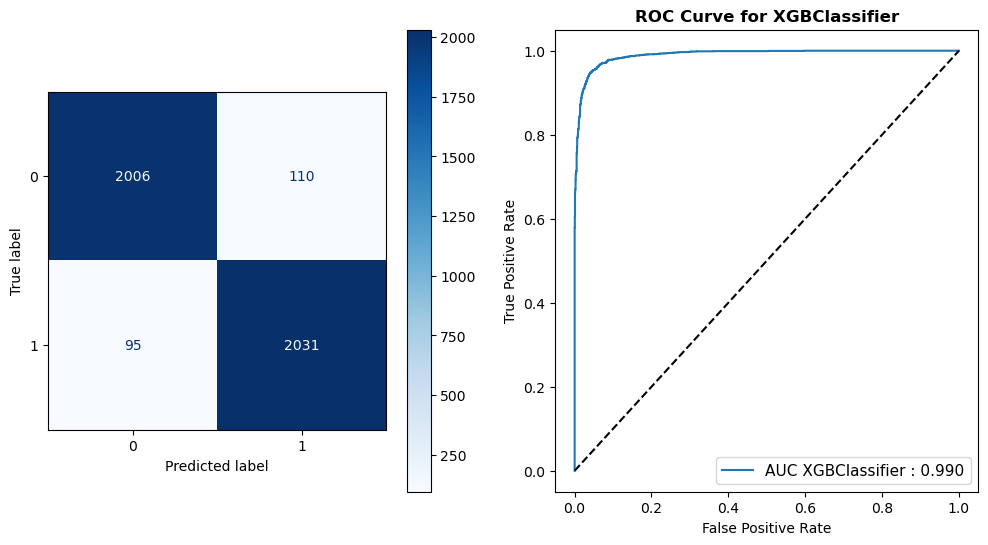

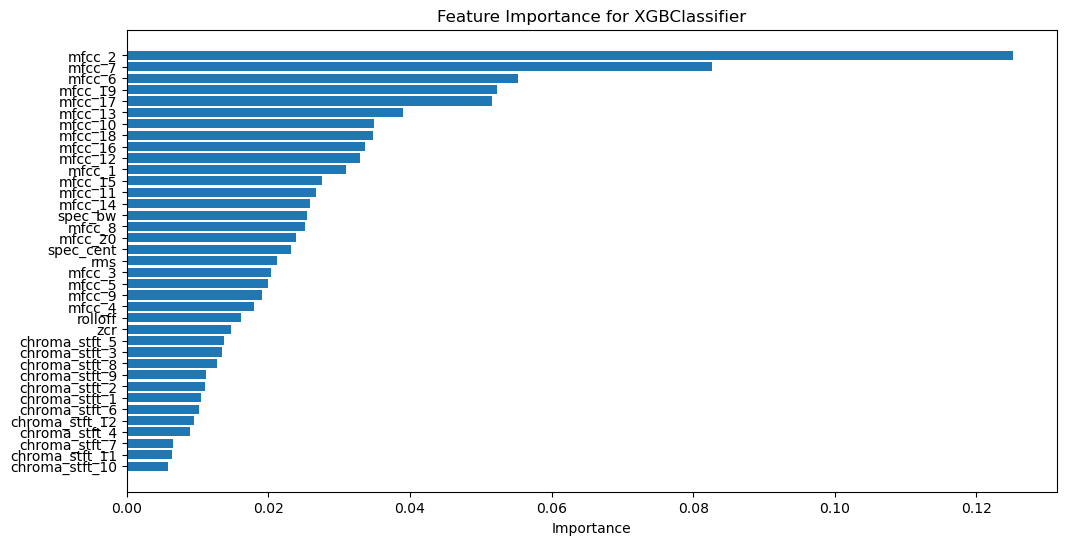

In [88]:
get_metrics(clf_xgb_best, X_test, y_test)

#### Distance-based

##### kNN

In [161]:
knn_clf = KNeighborsClassifier()

knn_params = {
    "n_neighbors": [1, 5, 10, 20, 50, 100],   
    "weights": ["uniform", "distance"],       
    "metric": ["euclidean", "manhattan", "minkowski"],  
}

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Parameters used:  {'n_neighbors': [1, 5, 10, 20, 50, 100], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}
[^_^] Best estimator:  KNeighborsClassifier(metric='euclidean', n_neighbors=10, weights='distance')
Best cross-validated score:  0.9348747204013448
Best parameters:  {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
This estimator's accuracy score:  0.9305912596401028
<===== Metrics for KNeighborsClassifier =====>
Average inference time (1s): 0.072 ms
              precision    recall  f1-score   support

           0      0.935     0.923     0.929      2116
           1      0.925     0.937     0.931      2126

    accuracy                          0.930      4242
   macro avg      0.930     0.930     0.930      4242
weighted avg      0.930     0.930     0.930      4242

[ACC] Accuracy: 0.930
-> [0]: 0.930
-> [1]: 0.930
[MCC] Matthews Correlation Coefficient (MCC)

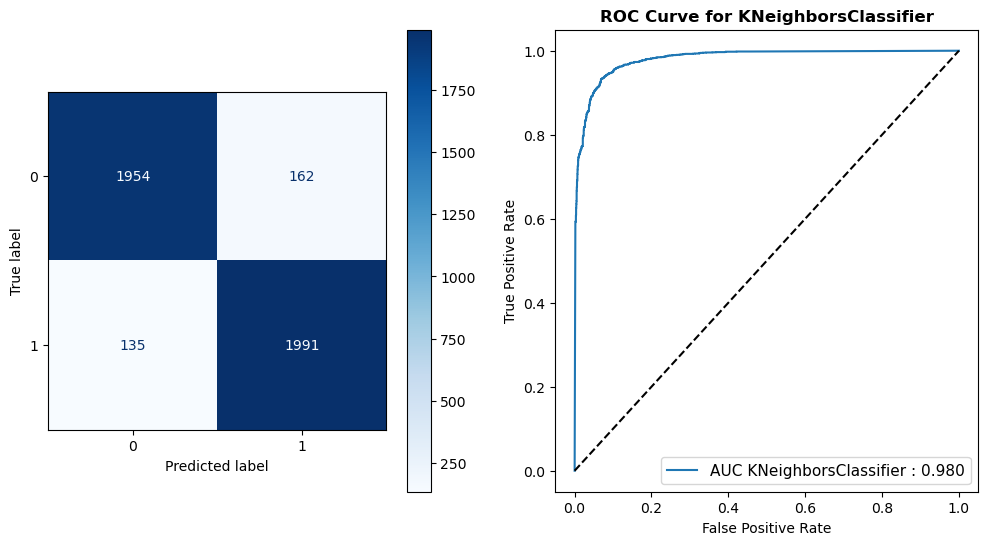

In [162]:
%%time
run_while_i_sleep(knn_clf, knn_params, X_train_s, y_train_s, X_test_s, y_test_s)

#### Tree-based

In [148]:
knn_clf = KNeighborsClassifier()

knn_params = {
    'n_neighbors': [1, 3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan']
}

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Parameters used:  {'n_neighbors': [1, 3, 5, 10, 20], 'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'euclidean', 'manhattan']}
[^_^] Best estimator:  KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')
Best cross-validated score:  0.8222983135156721
Best parameters:  {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
This estimator's accuracy score:  0.8348390085707668
<===== Metrics for KNeighborsClassifier =====>
Average inference time (1s): 0.178 ms
              precision    recall  f1-score   support

           0      0.842     0.816     0.829      2116
           1      0.822     0.848     0.835      2126

    accuracy                          0.832      4242
   macro avg      0.832     0.832     0.832      4242
weighted avg      0.832     0.832     0.832      4242

[ACC] Accuracy: 0.832
-> [0]: 0.832
-> [1]: 0.832
[MCC] Matthews Correlation Coefficient (MCC): 0.66

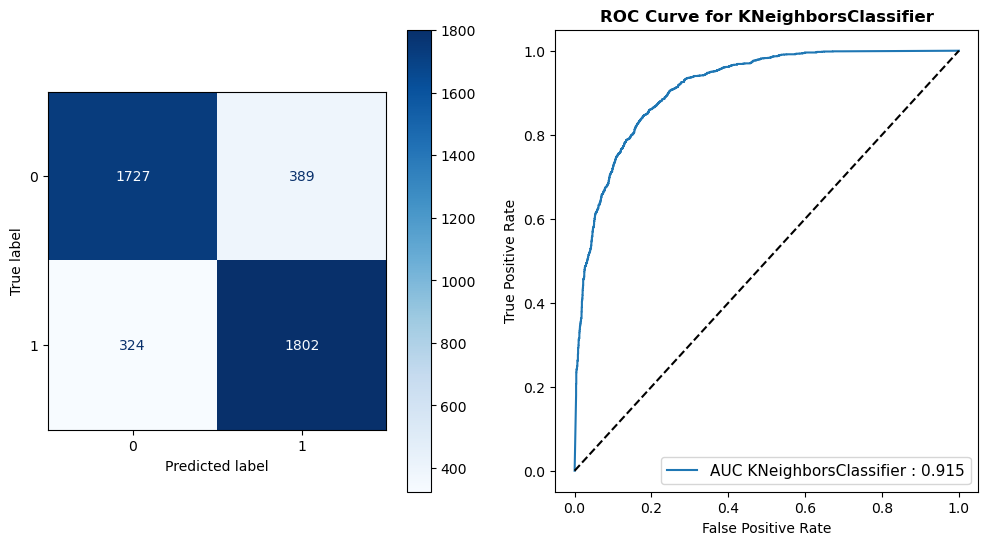

In [149]:
%%time
run_while_i_sleep(knn_clf, knn_params, X_train, y_train, X_test, y_test)

##### Random Forest

In [150]:
rf_clf = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': [5, 10, 20, 50], 
    'min_samples_split': [2, 10, 50, 100, 200, 500]
}

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Parameters used:  {'n_estimators': [5, 10, 20, 50], 'min_samples_split': [2, 10, 50, 100, 200, 500]}
[^_^] Best estimator:  RandomForestClassifier(n_estimators=50, random_state=42)
Best cross-validated score:  0.9206289046769358
Best parameters:  {'min_samples_split': 2, 'n_estimators': 50}
This estimator's accuracy score:  0.9144059869036483
<===== Metrics for RandomForestClassifier =====>
Average inference time (1s): 0.012 ms
              precision    recall  f1-score   support

           0      0.918     0.908     0.913      2116
           1      0.909     0.920     0.914      2126

    accuracy                          0.914      4242
   macro avg      0.914     0.914     0.914      4242
weighted avg      0.914     0.914     0.914      4242

[ACC] Accuracy: 0.914
-> [0]: 0.914
-> [1]: 0.914
[MCC] Matthews Correlation Coefficient (MCC): 0.827


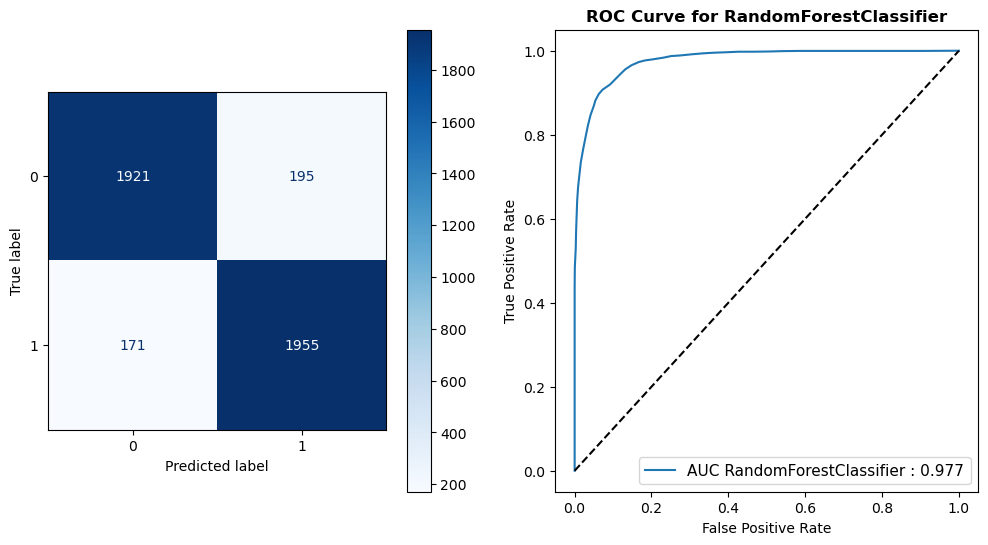

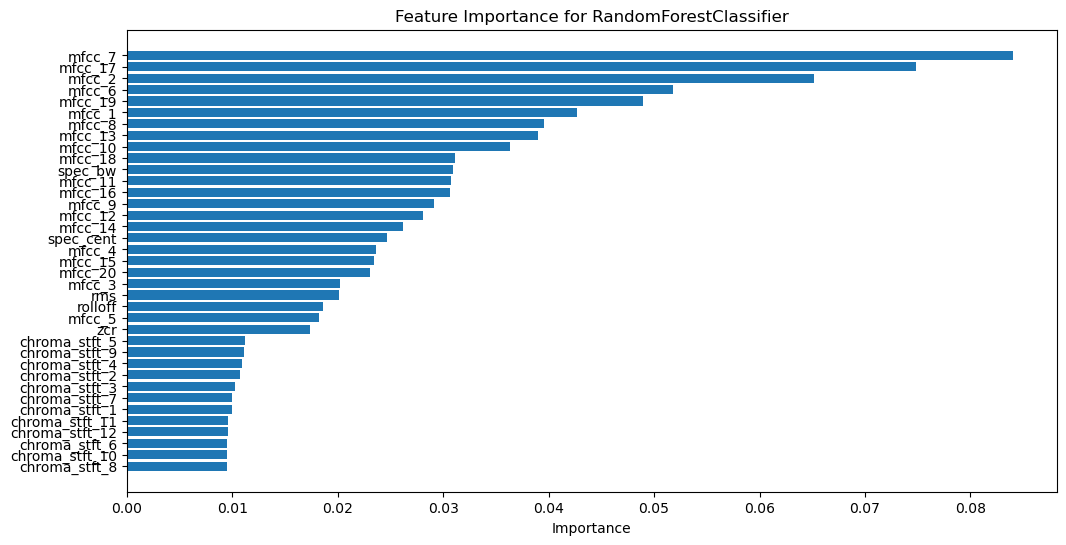

CPU times: total: 10.3 s
Wall time: 1min 20s


In [151]:
%%time
run_while_i_sleep(rf_clf, rf_params, X_train, y_train, X_test, y_test)

##### LightBGM

In [158]:
lgbm_clf = LGBMClassifier(random_state=42,verbose=-1)

lgbm_params = {
    'n_estimators': [50, 100, 200, 300, 400, 500, 800],
    'learning_rate':[5e-2],
    'max_depth': [4],
    'reg_alpha':[1e-1],
    'reg_lambda':[1e-3],
    'gamma':[0.3],
    'subsample':[0.9],
    'objective':['binary'],
    'eval_metric':['auc'],
    'scale_pos_weight':[1]
}

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Parameters used:  {'n_estimators': [50, 100, 200, 300, 400, 500, 800], 'learning_rate': [0.05], 'max_depth': [4], 'reg_alpha': [0.1], 'reg_lambda': [0.001], 'gamma': [0.3], 'subsample': [0.9], 'objective': ['binary'], 'eval_metric': ['auc'], 'scale_pos_weight': [1]}
[^_^] Best estimator:  LGBMClassifier(eval_metric='auc', gamma=0.3, learning_rate=0.05, max_depth=4,
               n_estimators=800, objective='binary', random_state=42,
               reg_alpha=0.1, reg_lambda=0.001, scale_pos_weight=1,
               subsample=0.9, verbose=-1)
Best cross-validated score:  0.9421033575050888
Best parameters:  {'eval_metric': 'auc', 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 800, 'objective': 'binary', 'reg_alpha': 0.1, 'reg_lambda': 0.001, 'scale_pos_weight': 1, 'subsample': 0.9}
This estimator's accuracy score:  0.9382600561272217
<===== Metrics for LGBMClassifier =====>
Average inference time (1s): 0.

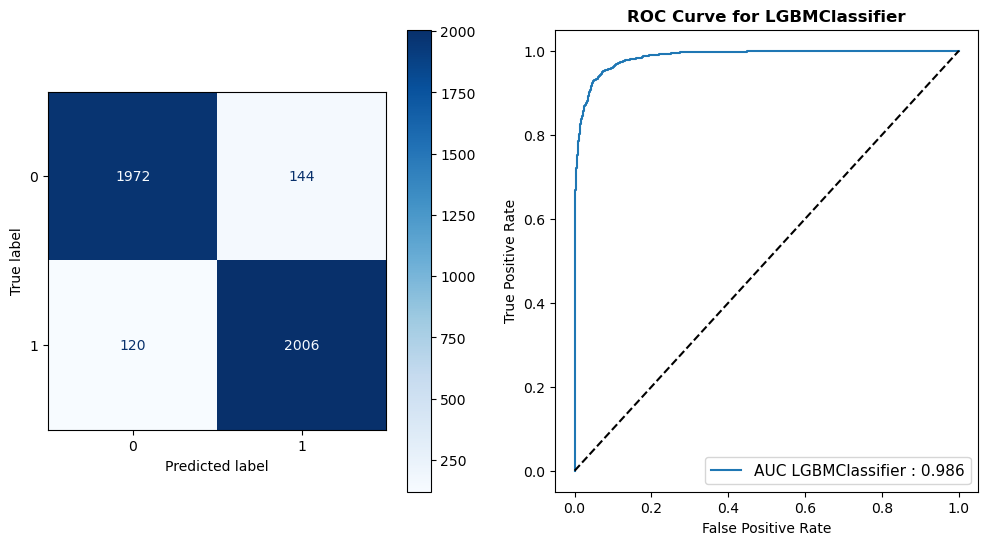

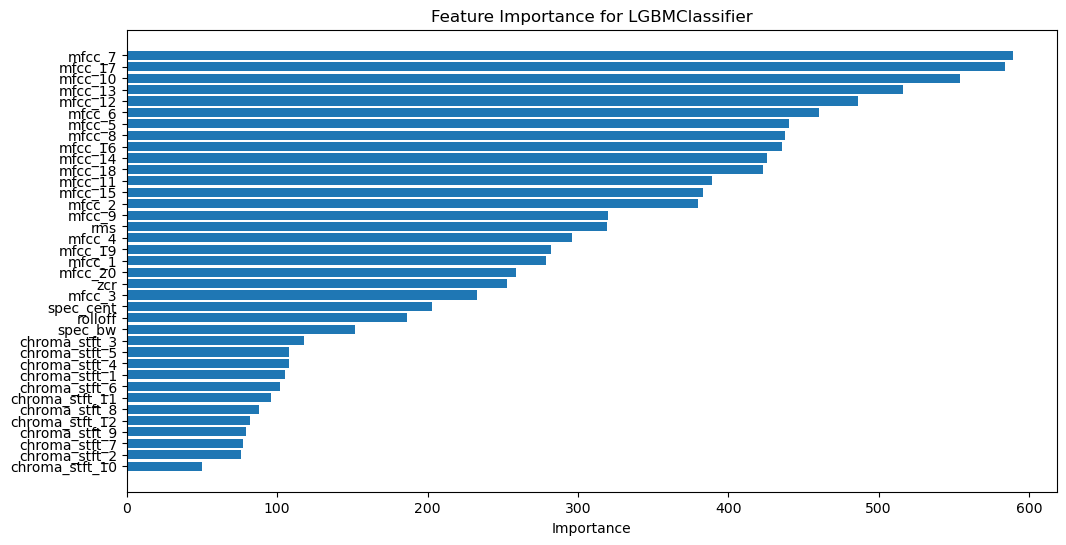

CPU times: total: 12 s
Wall time: 51.6 s


In [159]:
%%time
run_while_i_sleep(lgbm_clf, lgbm_params, X_train, y_train, X_test, y_test)

##### CatBoost

In [160]:
cb_clf = CatBoostClassifier(random_state=42)

cb_params ={
    'n_estimators': [50, 100, 200, 300, 400, 500, 800],
    'learning_rate':[5e-2],
    'max_depth': [4],
    'reg_lambda':[1],
    'bootstrap_type': ['Bernoulli'],
    'subsample':[0.95],
    'eval_metric':['AUC'],
    'scale_pos_weight':[15],
    'logging_level':['Silent']
}

Fitting 10 folds for each of 7 candidates, totalling 70 fits


C:\Users\lenovo\anaconda3_\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
1 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lenovo\anaconda3_\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lenovo\anaconda3_\Lib\site-packages\catboost\core.py", line 5201, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\lenovo\anaconda3_\Lib\site-packages\catboost\core.py", line 2

Parameters used:  {'n_estimators': [50, 100, 200, 300, 400, 500, 800], 'learning_rate': [0.05], 'max_depth': [4], 'reg_lambda': [1], 'bootstrap_type': ['Bernoulli'], 'subsample': [0.95], 'eval_metric': ['AUC'], 'scale_pos_weight': [15], 'logging_level': ['Silent']}
[^_^] Best estimator:  <catboost.core.CatBoostClassifier object at 0x0000023DEF018F90>
Best cross-validated score:  0.8762578377393921
Best parameters:  {'bootstrap_type': 'Bernoulli', 'eval_metric': 'AUC', 'learning_rate': 0.05, 'logging_level': 'Silent', 'max_depth': 4, 'n_estimators': 800, 'reg_lambda': 1, 'scale_pos_weight': 15, 'subsample': 0.95}
This estimator's accuracy score:  0.8738105088953247
<===== Metrics for CatBoostClassifier =====>
Average inference time (1s): 0.007 ms
              precision    recall  f1-score   support

           0      0.991     0.718     0.833      2116
           1      0.780     0.993     0.874      2126

    accuracy                          0.856      4242
   macro avg      0.885   

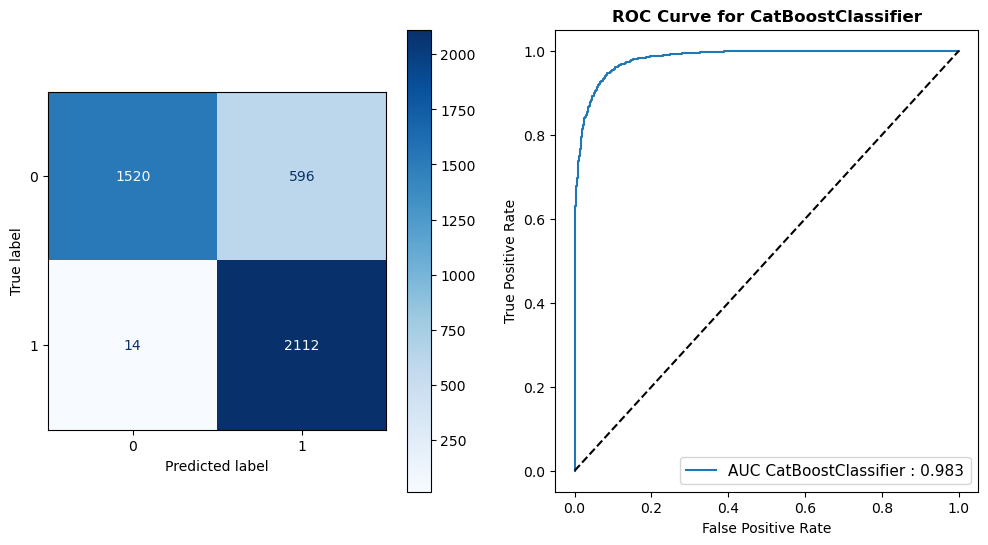

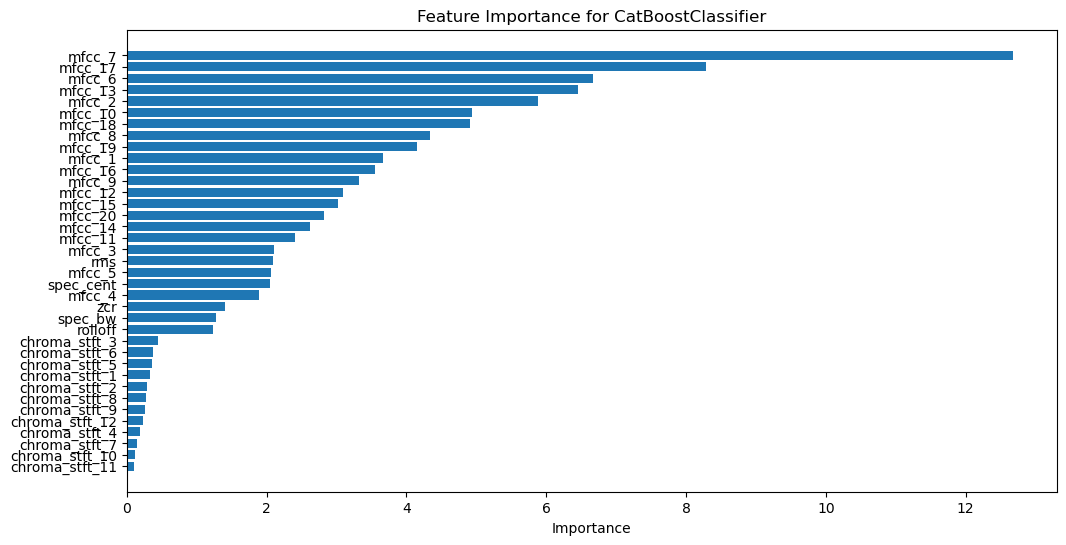

CPU times: total: 49.2 s
Wall time: 1min 46s


In [161]:
%%time
run_while_i_sleep(cb_clf, cb_params, X_train, y_train, X_test, y_test)

#### SVMs

##### SGD

In [164]:
sgd_clf = SGDClassifier(random_state=42, fit_intercept=False,max_iter=20000) # faster!

sgd_params = {
    'loss':['hinge', 'log_loss', 'modified_huber'],
    'penalty':['l1','l2'],
    'class_weight':['balanced', None], #balance as res_array have same weight throughout       
} 

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Parameters used:  {'loss': ['hinge', 'log_loss', 'modified_huber'], 'penalty': ['l1', 'l2'], 'class_weight': ['balanced', None]}
[^_^] Best estimator:  SGDClassifier(fit_intercept=False, loss='log_loss', max_iter=20000,
              penalty='l1', random_state=42)
Best cross-validated score:  0.8289071200900701
Best parameters:  {'class_weight': None, 'loss': 'log_loss', 'penalty': 'l1'}
This estimator's accuracy score:  0.827435773145904
<===== Metrics for SGDClassifier =====>
Average inference time (1s): 0.001 ms
              precision    recall  f1-score   support

           0      0.813     0.862     0.837      2116
           1      0.854     0.803     0.827      2126

    accuracy                          0.832      4242
   macro avg      0.833     0.832     0.832      4242
weighted avg      0.833     0.832     0.832      4242

[ACC] Accuracy: 0.832
-> [0]: 0.832
-> [1]: 0.832
[MCC] Matthews Correlation Coefficient 

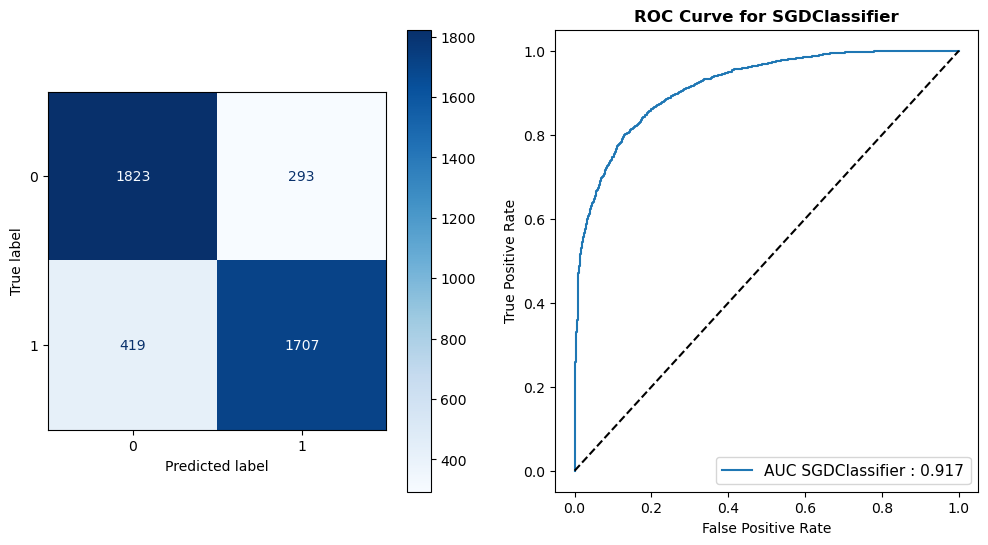

In [165]:
%%time
run_while_i_sleep(sgd_clf, sgd_params, X_train_s, y_train_s, X_test_s, y_test_s)

##### SVM

In [178]:
svc_clf = SVC(random_state=42)

svc_params= {
    'kernel':['poly','rbf','sigmoid'],
    'C': [0.01,0.1,1,10,50,100],
}

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Parameters used:  {'kernel': ['poly', 'rbf', 'sigmoid'], 'C': [0.01, 0.1, 1, 10, 50, 100]}
[^_^] Best estimator:  SVC(C=10, probability=True, random_state=42)
Best cross-validated score:  0.9601179939050807
Best parameters:  {'C': 10, 'kernel': 'rbf'}
This estimator's accuracy score:  0.9571929824561404
<===== Metrics for SVC =====>
Average inference time (1s): 0.318 ms
              precision    recall  f1-score   support

           0      0.962     0.951     0.957      2116
           1      0.952     0.962     0.957      2126

    accuracy                          0.957      4242
   macro avg      0.957     0.957     0.957      4242
weighted avg      0.957     0.957     0.957      4242

[ACC] Accuracy: 0.957
-> [0]: 0.957
-> [1]: 0.957
[MCC] Matthews Correlation Coefficient (MCC): 0.914
[!] Feature importance cannot be applied to SVC. Skipping...
CPU times: total: 27.2 s
Wall time: 22min 15s


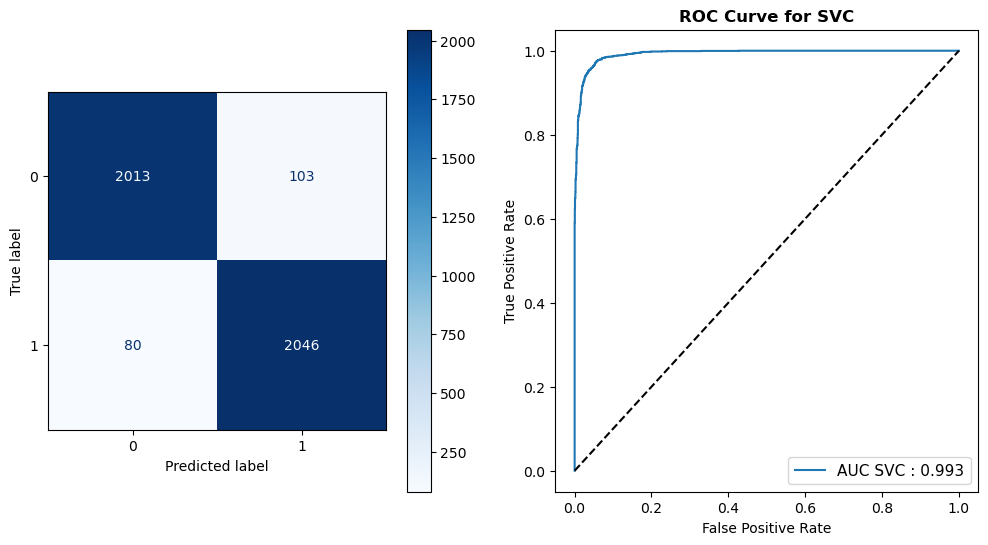

In [167]:
%%time
run_while_i_sleep(svc_clf, svc_params, X_train_s, y_train_s, X_test_s, y_test_s)

#### Linear

##### LogisticRegression

In [172]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [38]:
lr_clf = LogisticRegression()

lr_params = {
    
    'C': [0.01, 0.05, 0.1, 1, 10, 50, 100],
    'penalty': ['l2', None], 
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced']
}

Fitting 10 folds for each of 56 candidates, totalling 560 fits


C:\Users\lenovo\anaconda3_\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
140 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lenovo\anaconda3_\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lenovo\anaconda3_\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lenovo\anaconda3_\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1218, in fit
   

Parameters used:  {'C': [0.01, 0.05, 0.1, 1, 10, 50, 100], 'penalty': ['l2', None], 'solver': ['lbfgs', 'liblinear'], 'class_weight': [None, 'balanced']}
[^_^] Best estimator:  LogisticRegression(C=10, solver='liblinear')
Best cross-validated score:  0.8331460600086888
Best parameters:  {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
This estimator's accuracy score:  0.8272748871465906
<===== Metrics for LogisticRegression =====>
Average inference time (1s): 0.001 ms
              precision    recall  f1-score   support

           0      0.822     0.838     0.830      2116
           1      0.836     0.819     0.827      2126

    accuracy                          0.829      4242
   macro avg      0.829     0.829     0.829      4242
weighted avg      0.829     0.829     0.829      4242

[ACC] Accuracy: 0.829
-> [0]: 0.829
-> [1]: 0.829
[MCC] Matthews Correlation Coefficient (MCC): 0.657
[!] Feature importance cannot be applied to LogisticRegression. Skipping...

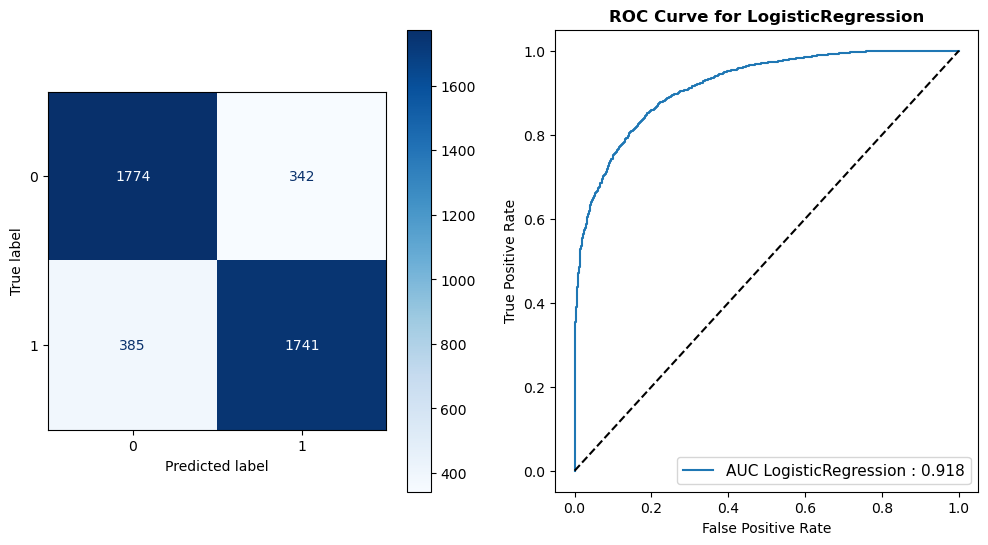

In [39]:
%%time
run_while_i_sleep(lr_clf, lr_params, X_train, y_train, X_test, y_test)

##### Ridge

In [173]:
rd_clf = RidgeClassifier()

rd_params = {
    'alpha': [0.01, 0.05, 0.1, 1, 10, 50, 100],
    'solver': ['auto', 'lsqr', 'lbfgs'],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False]
}

Fitting 10 folds for each of 84 candidates, totalling 840 fits


C:\Users\lenovo\anaconda3_\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
280 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lenovo\anaconda3_\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lenovo\anaconda3_\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lenovo\anaconda3_\Lib\site-packages\sklearn\linear_model\_ridge.py", line 1570, in fit
    su

Parameters used:  {'alpha': [0.01, 0.05, 0.1, 1, 10, 50, 100], 'solver': ['auto', 'lsqr', 'lbfgs'], 'class_weight': [None, 'balanced'], 'fit_intercept': [True, False]}
[^_^] Best estimator:  RidgeClassifier(alpha=10, class_weight='balanced')
Best cross-validated score:  0.8390651576748457
Best parameters:  {'alpha': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'solver': 'auto'}
This estimator's accuracy score:  0.8375296912114014
<===== Metrics for RidgeClassifier =====>
Average inference time (1s): 0.001 ms
              precision    recall  f1-score   support

           0      0.832     0.848     0.840      2116
           1      0.846     0.829     0.838      2126

    accuracy                          0.839      4242
   macro avg      0.839     0.839     0.839      4242
weighted avg      0.839     0.839     0.839      4242

[ACC] Accuracy: 0.839
-> [0]: 0.839
-> [1]: 0.839
[MCC] Matthews Correlation Coefficient (MCC): 0.678
[!] Error for RidgeClassifier: 'RidgeClassifier

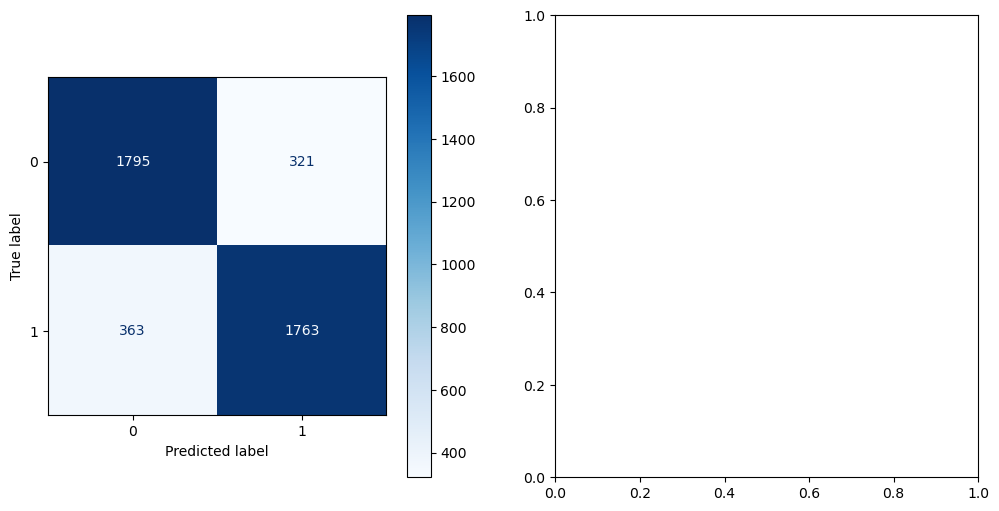

In [177]:
%%time
run_while_i_sleep(rd_clf, rd_params, X_train_s, y_train_s, X_test_s, y_test_s)

### Processing Time (Demo)

In [90]:
import random

In [91]:
def get_features_row_demo(input_audio_path, label, frame_length_sec):
    print(f"<==== Current audio: {os.path.basename(input_audio_path)} [{label}] ====>")
    y, sr = librosa.load(input_audio_path, sr=None)
    print("sr: ", sr)

    block_length = sr  # 1 second block
    overlap_constant = 0.6354 # Paper's overlapping value
    #hop = int(sr * overlap_constant)
    hop = int(sr * 0.6354)
    duration = librosa.get_duration(y=y, sr=sr)
    print(f"Audio length: {duration:.2f} seconds")

    # Number of blocks
    num_blocks = int((len(y) - block_length) / hop) + 1
    features = []
    processing_times = []

    # Convert frame length to samples
    frame_length_samples = int(frame_length_sec * sr) if frame_length_sec != 1 else sr + 1 # whole block as frame!
    hop_frame = frame_length_samples # no overlap between frames within block

    for i in range(num_blocks): # per 1s blocks
        begin = time.time()
        start = i * hop
        end = start + block_length
        block = y[start:end]

        num_frames = int((len(block) - frame_length_samples) / hop_frame) + 1
        
        for j in range(num_frames):
            start_frame = j * hop_frame
            end_frame = start_frame + frame_length_samples
            frame = block[start_frame:end_frame]
            n_fft=frame_length_samples+1
            hop_length=frame_length_samples+1

            # Compute features per frame (no overlap)
            chroma = librosa.feature.chroma_stft(y=frame, n_fft=n_fft, hop_length=hop_length).flatten()
            rms = librosa.feature.rms(y=frame, hop_length=hop_length).flatten()
            spec_cent = librosa.feature.spectral_centroid(y=frame, n_fft=n_fft, hop_length=hop_length).flatten()
            spec_bw = librosa.feature.spectral_bandwidth(y=frame, n_fft=n_fft, hop_length=hop_length).flatten()
            rolloff = librosa.feature.spectral_rolloff(y=frame, n_fft=n_fft, hop_length=hop_length).flatten()
            zcr = librosa.feature.zero_crossing_rate(y=frame, frame_length=n_fft, hop_length=hop_length).flatten()
            mfcc = librosa.feature.mfcc(y=frame, n_mfcc=20, n_fft=n_fft, hop_length=hop_length).flatten()

            features.append(np.concatenate([chroma, rms, spec_cent, spec_bw, rolloff, zcr, mfcc]))
            
        processing_times.append(time.time() - begin)
        
    df = pd.DataFrame(features, columns=col_names)
    df["LABEL"] = label
    avg_time = np.mean(processing_times)
    print(f"==> {os.path.basename(input_audio_path)}: Success! Average processing time (1 second blocks): {avg_time:.3f}s ({avg_time*1000:.3f}ms)")
    return df, avg_time

In [92]:
def get_scaled_demo(df, scaler_obj):
    begin = time.time()
    original_features = df.drop(columns=["LABEL"])
    original_labels = df["LABEL"]
    scaled_features = pd.DataFrame(scaler_obj.fit_transform(original_features), columns=original_features.columns)

    scaled_dataset_balance = pd.concat([scaled_features, original_labels], axis=1)
    #plot_feature_correlation(scaled_dataset_balance, f"PCA Feature Correlation using ({scaler_obj})")
    avg_time = time.time() - begin
    return scaled_dataset_balance, avg_time

In [99]:
def get_metrics_demo(clf, X_test, y_test):
    print(f"<===== Metrics for {clf.__class__.__name__} =====>")
    start = time.time()
    y_pred = clf.predict(X_test)
    end = time.time()
    avg = (end - start)/len(X_test) 

    # Average time per 1 sec block
    print(f"Average inference time (1s): {avg * 1000:.3f} ms")
    
    # Plot
    #plt.figure(figsize=(8,5))
    #for label in labels:
        #plt.plot(running_conf[label], marker='o', label=f"Label {label}")
    
        
    # overview
    print(classification_report(y_test, y_pred, digits=3))
          
    # Accuracy score
    print(f"[ACC] Accuracy: {accuracy_score(y_test, y_pred):.3f}")

    # Accuracy score per class
    #for c in clf.classes_:
        #print(f"-> [{c}]: {extended_accuracy_score(y_test, y_pred, method='binary', pos_label=c):.3f}")

    # MCC
    print(f"[MCC] Matthews Correlation Coefficient (MCC): {matthews_corrcoef(y_test, y_pred):.3f}")

    ## Plots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #disp.plot(cmap='Blues', ax=ax[0])

    # ROC Curve
    #plot_roc_curve_manual(clf, X_test, y_test, clf.__class__.__name__, ax[1])

    # Get importance
    try:
        #importance = clf.feature_importances_
        
        #feature_importance_df = pd.DataFrame({'Feature': X.columns,'Importance': importance}).sort_values(by='Importance', ascending=False)
        
        #plt.figure(figsize=(12,6))
        #plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
        #plt.xlabel("Importance")
        #plt.title(f"Feature Importance for {clf.__class__.__name__}")
        #plt.gca().invert_yaxis() 
        #plt.show()
        return avg
    except:
        print(f"[!] Feature importance cannot be applied to {clf.__class__.__name__}. Skipping...")

    return avg

In [100]:
targets = [r"C:\Users\lenovo\Downloads\visal-pewdipie.wav", # F
          r"C:\Users\lenovo\Downloads\visal-gura.wav", # F
          r"C:\Users\lenovo\Downloads\ryan-original.wav",
          r"C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\visal.wav",
         ]

scalers = ["SVC", "SGDClassifier", "KNeighborsClassifier", "LogisticRegression", "RidgeClassifier"]

def demo(targets):
    for dirpath, dirnames, filenames in os.walk(r"C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD"):
        for f in filenames:
            if f.lower().endswith(".joblib"): 
                full_path = os.path.join(dirpath, f)
                clf = load(full_path)
                print(f"<<=============== MODEL {clf.__class__.__name__} ===============>>")
                feature_extraction_times = []
                inference_times = []
                scaling_times = []
                
                for i in range(10):
                    print(f"++++ Round {i} ++++")
                    j = random.randint(0, len(targets)-1)
                    label = "FAKE" if j <= 1 else "REAL"
                    df, feat_time = get_features_row_demo(targets[j], label, 1)
                    feature_extraction_times.append(feat_time)
                    print("Wating 5s...")
                    time.sleep(5)

                    if clf.__class__.__name__ in scalers:
                        print("Scaling...")
                        dfs, scaling_time = get_scaled_demo(df, RobustScaler())
                        X_demo = dfs.drop(columns='LABEL')
                        y_demo = (dfs['LABEL'] == 'FAKE').astype(int)  # 0 -> REAL, 1 -> FAKE
                        scaling_times.append(scaling_time)
    
                        infer_time = get_metrics_demo(clf, X_demo, y_demo)         
                        inference_times.append(infer_time)
                        
                    else:    
                        X_demo = df.drop(columns='LABEL')
                        y_demo = (df['LABEL'] == 'FAKE').astype(int)  # 0 -> REAL, 1 -> FAKE
    
                        infer_time = get_metrics_demo(clf, X_demo, y_demo)         
                        inference_times.append(infer_time)
                    print("Wating 10s before next model...")
                    time.sleep(10)
                print(f"Averaged metrics for MODEL {clf.__class__.__name__}")
                print(f"Feature extraction: ${np.mean(feature_extraction_times)*1000:.3f} \pm {np.std(feature_extraction_times)*1000:.3f}$")
                print(f"Inference: ${np.mean(inference_times)*1000:.3f} \pm {np.std(inference_times)*1000:.3f}$")
                if clf.__class__.__name__ in scalers:
                    print(f"Scaling: ${np.mean(scaling_times)*1000:.3f} \pm {np.std(scaling_times)*1000:.3f}$")

### Extra: RVC results

In [2]:
import librosa.display
import IPython.display as ipd
from pydub import AudioSegment
from pydub.utils import mediainfo
from scipy import signal

In [58]:
def plot_amplitude(filepath):
    speech_audio = AudioSegment.from_wav(filepath).set_channels(1)
    s = speech_audio.get_array_of_samples() # samples x(t)
    f = speech_audio.frame_rate # sampling rate f
    
    plt.figure(figsize = (15, 5))
    plt.plot(s)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.title(f"Amplitude | '{filepath}'")

In [70]:
def plot_melspec(audio_path): # RETURNS DF OF SC FOR THIS AUDIO
    # load audio, get samples + sr
    speech = AudioSegment.from_wav(audio_path).set_channels(1) #Read audio data from file
    samples = speech.get_array_of_samples() #samples x(t)
    sampling_rate = speech.frame_rate #sampling rate f
    
    # get mel spectrum per frame
    melspec = librosa.feature.melspectrogram(y = np.float32(samples), sr = sampling_rate, hop_length = 512, n_fft = 2048, power = 2)

    # display
    S_dB = librosa.power_to_db(melspec, ref=np.max)

    plt.figure(figsize=(15, 5))
    librosa.display.specshow(S_dB, sr=sampling_rate, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel Spectrogram | '{audio_path}'")
    plt.tight_layout()

In [60]:
def plot_fft(audio_path):
    n_fft = 2048
    speech = AudioSegment.from_wav(audio_path).set_channels(1) #Read audio data from file
    samples = speech.get_array_of_samples() #samples x(t)
    sampling_rate = speech.frame_rate
    ft = np.abs(librosa.stft(np.float32(samples)))
    plt.figure(figsize=(15, 5))
    plt.plot(ft)
    plt.title(f"FFT | '{audio_path}'")
    plt.xlabel('Frequency Bin')
    plt.ylabel('Amplitude')

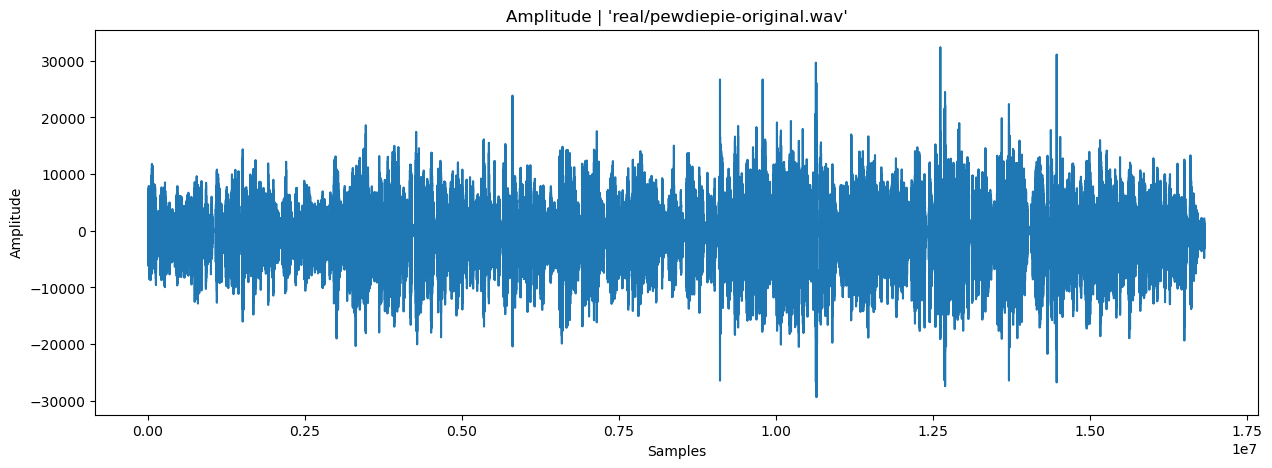

In [66]:
plot_amplitude(r"real/pewdiepie-original.wav")
plt.savefig(r"rvc/amp_real_pewds.png")
plt.show()

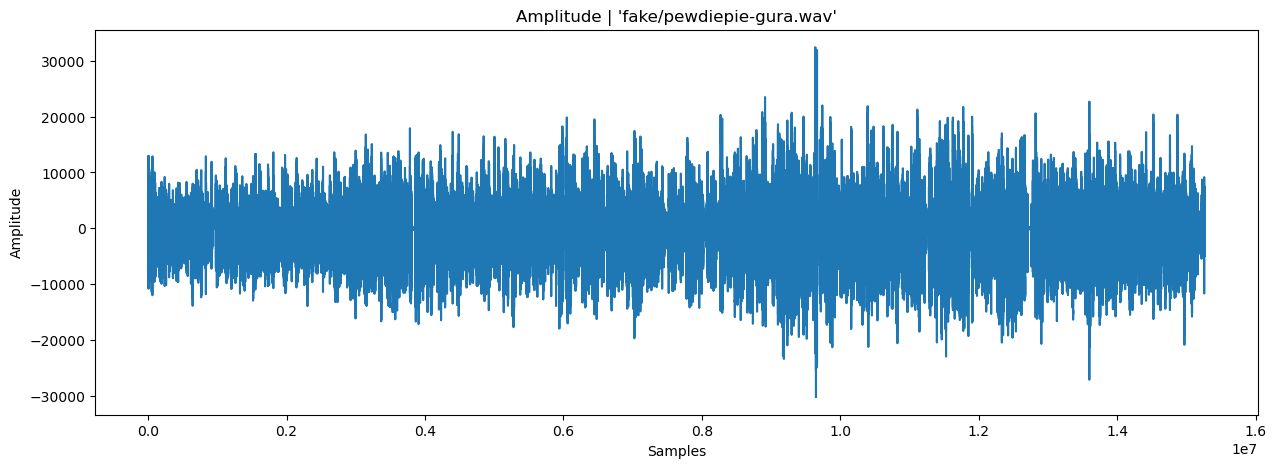

In [67]:
plot_amplitude(r"fake/pewdiepie-gura.wav")
plt.savefig(r"rvc/amp_fake_pewds_gura.png")
plt.show()

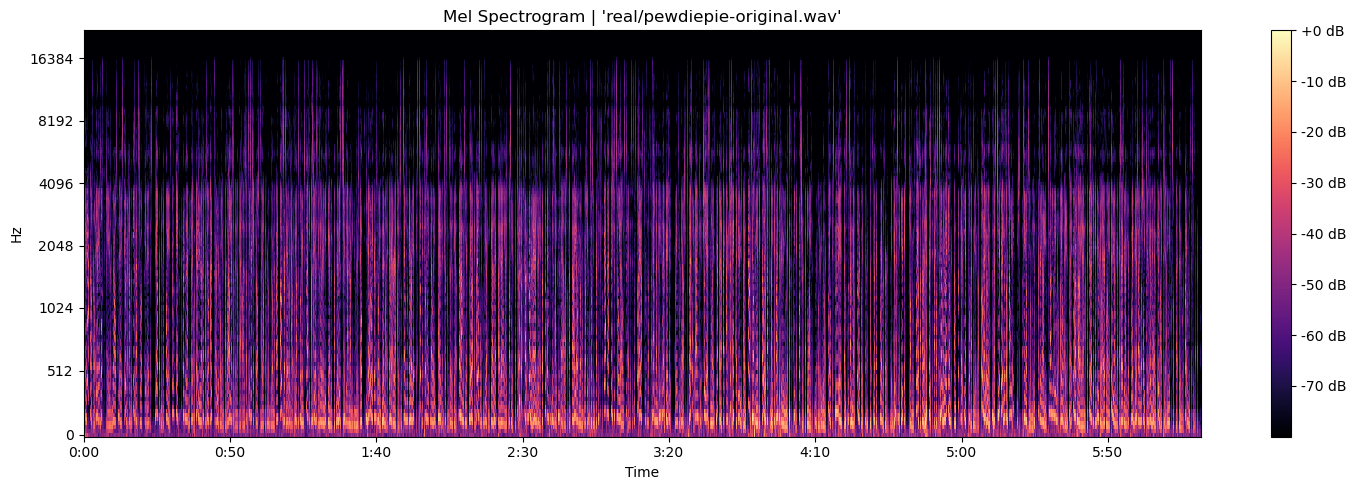

In [71]:
plot_melspec(r"real/pewdiepie-original.wav")
plt.savefig(r"rvc/mel_real_pewds.png")
plt.show()

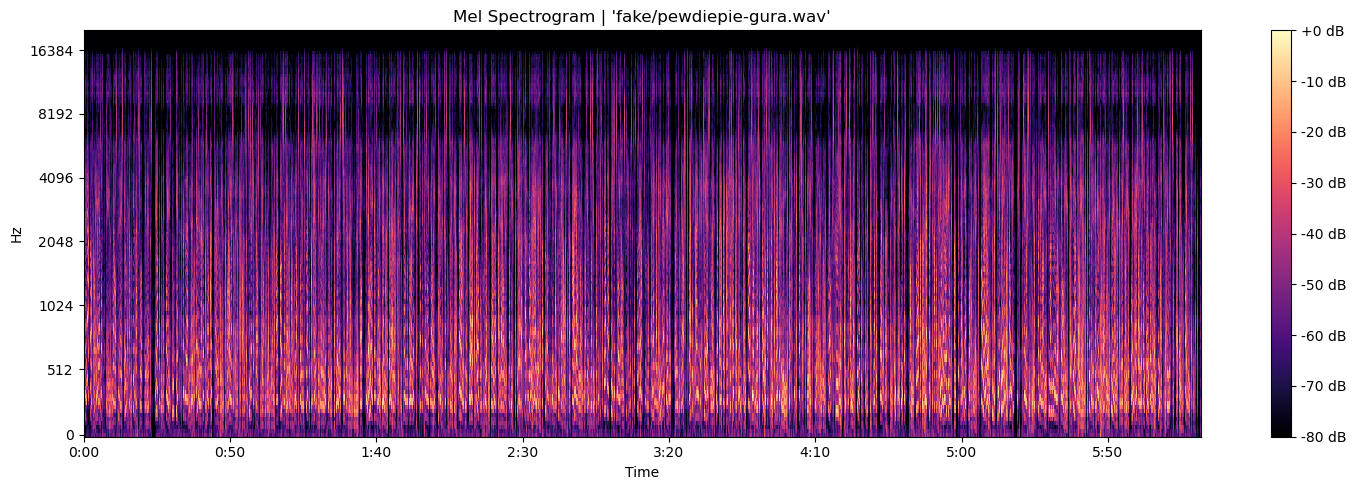

In [72]:
plot_melspec(r"fake/pewdiepie-gura.wav")
plt.savefig(r"rvc/mel_fake_pewds_gura.png")
plt.show()

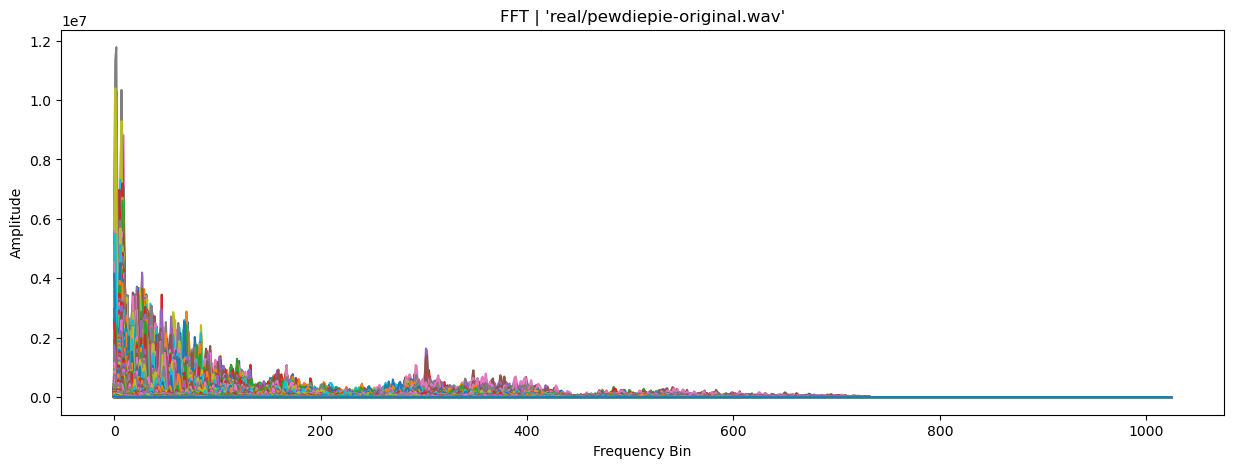

In [73]:
plot_fft(r"real/pewdiepie-original.wav")
plt.savefig(r"rvc/fft_real_pewds.png")
plt.show()

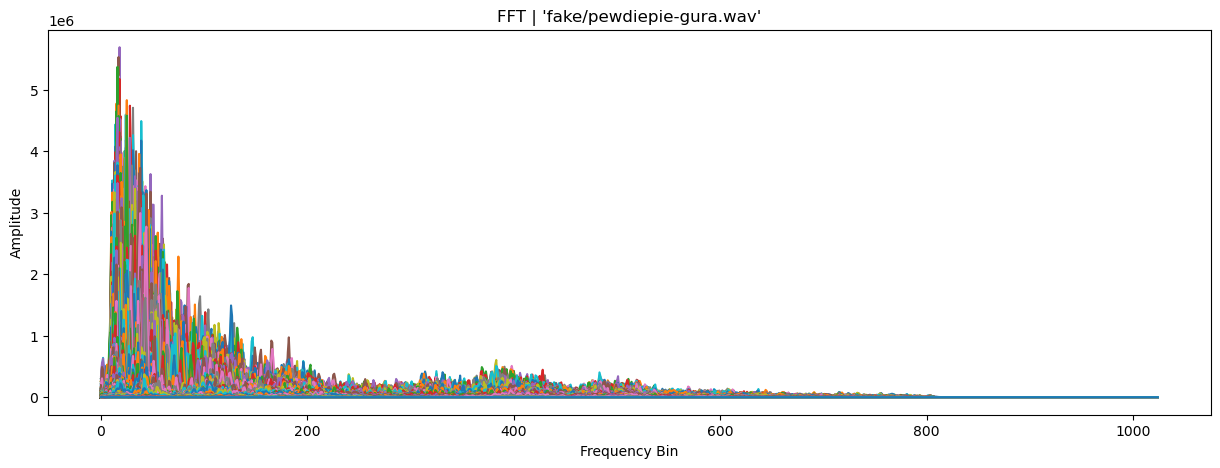

In [74]:
plot_fft(r"fake/pewdiepie-gura.wav")
plt.savefig(r"rvc/fft_fake_pewds_gura.png")
plt.show()

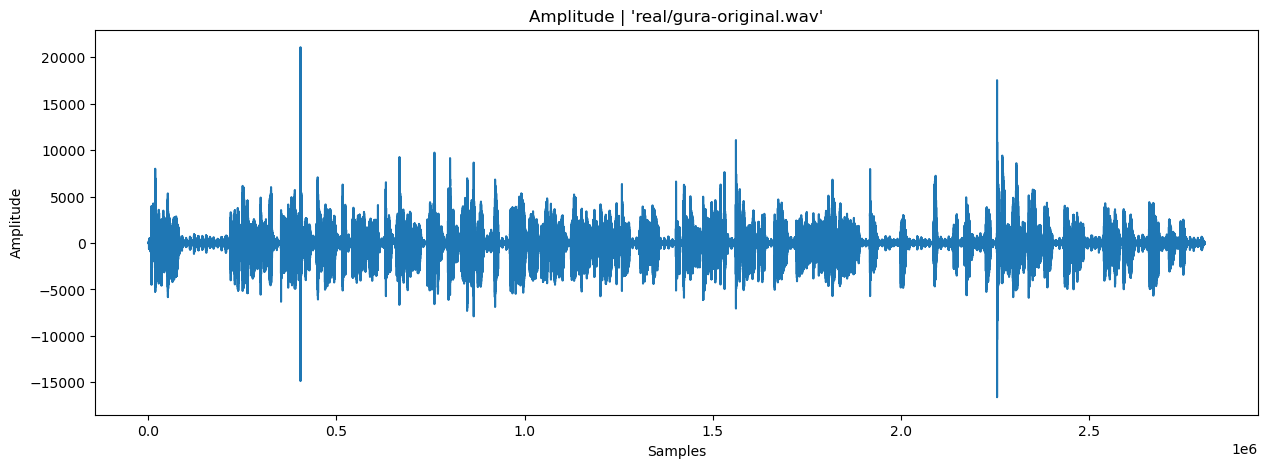

In [75]:
plot_amplitude(r"real/gura-original.wav")
plt.savefig(r"rvc/amp_gura.png")
plt.show()

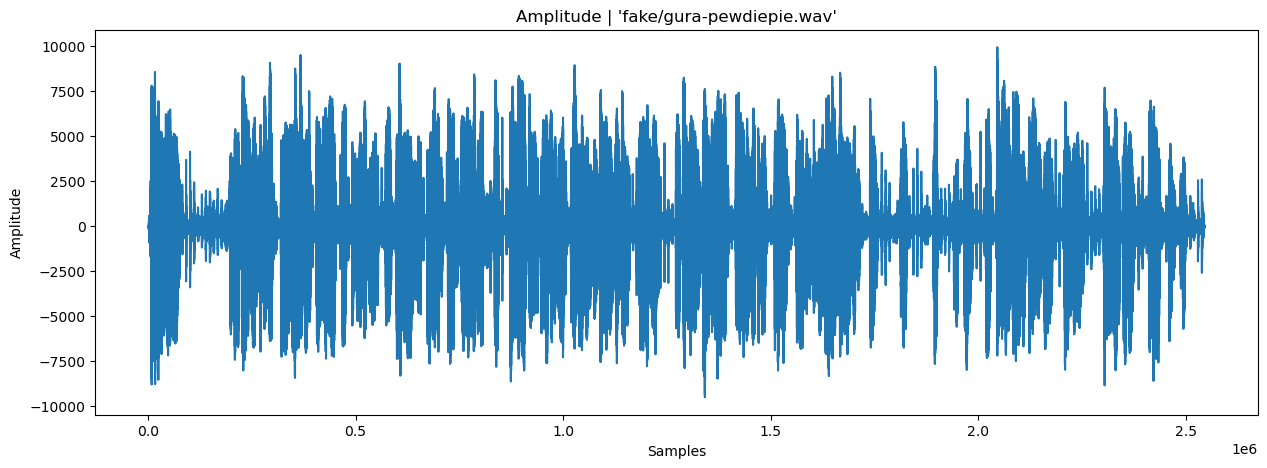

In [76]:
plot_amplitude(r"fake/gura-pewdiepie.wav")
plt.savefig(r"rvc/amp_gura_pewds.png")
plt.show()

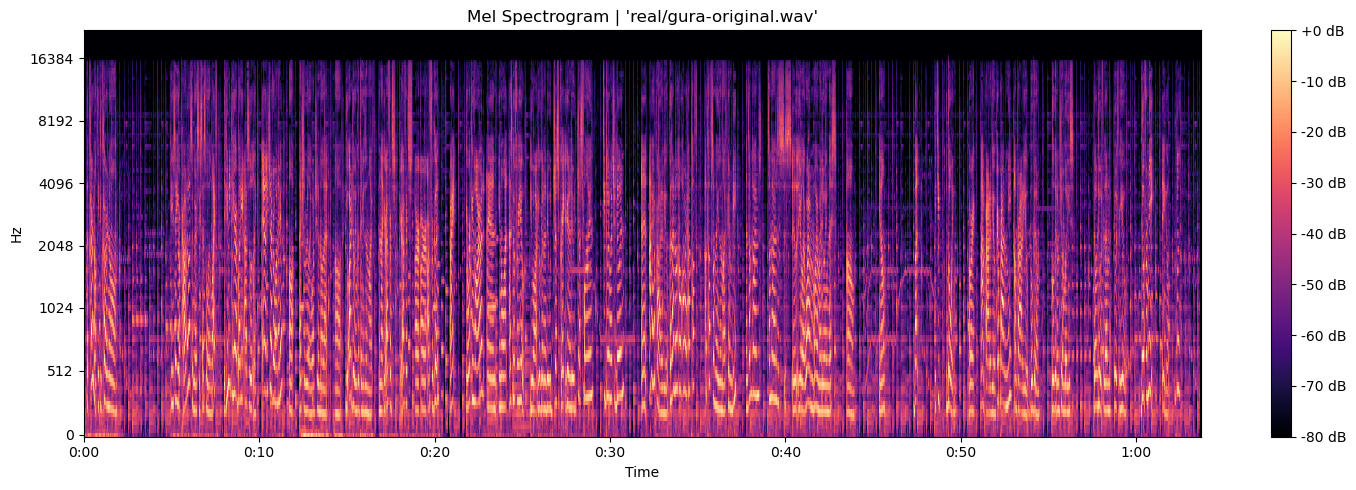

In [77]:
plot_melspec(r"real/gura-original.wav")
plt.savefig(r"rvc/melspec_gura.png")
plt.show()

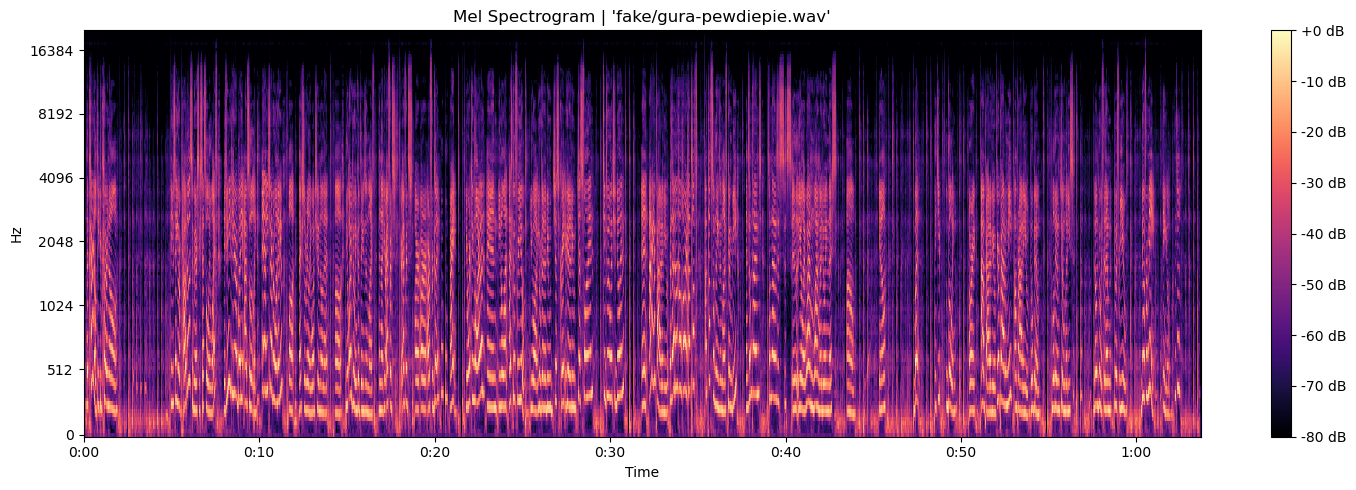

In [78]:
plot_melspec(r"fake/gura-pewdiepie.wav")
plt.savefig(r"rvc/melspec_gura_pewds.png")
plt.show()

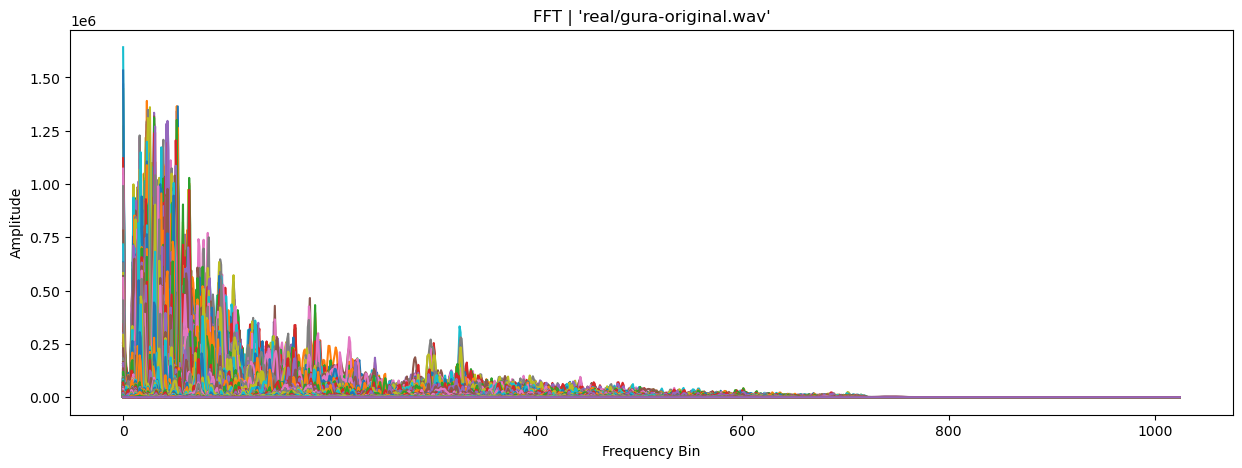

In [79]:
plot_fft(r"real/gura-original.wav")
plt.savefig(r"rvc/fft_gura.png")
plt.show()

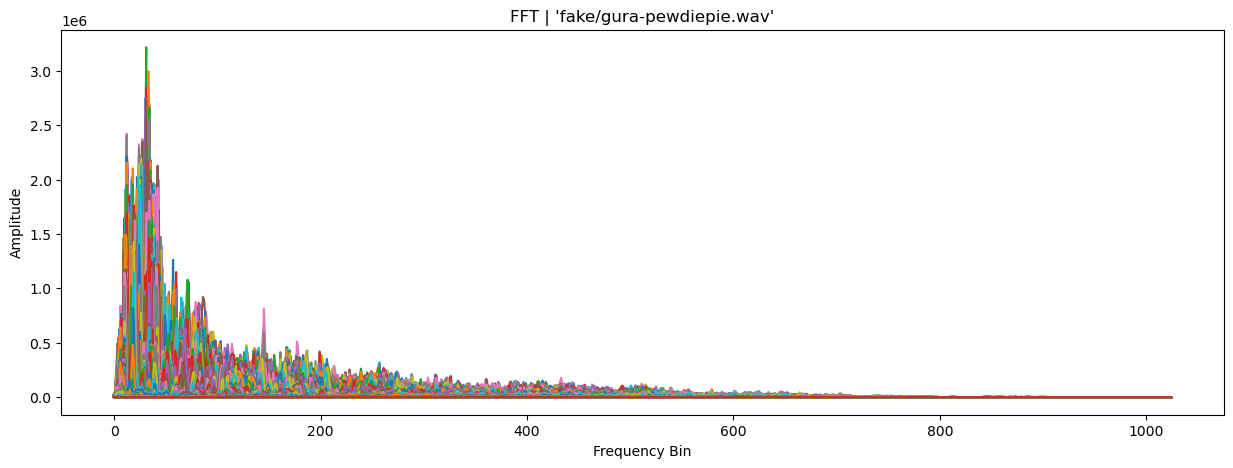

In [80]:
plot_fft(r"fake/gura-pewdiepie.wav")
plt.savefig(r"rvc/fft_gura_pewds.png")
plt.show()

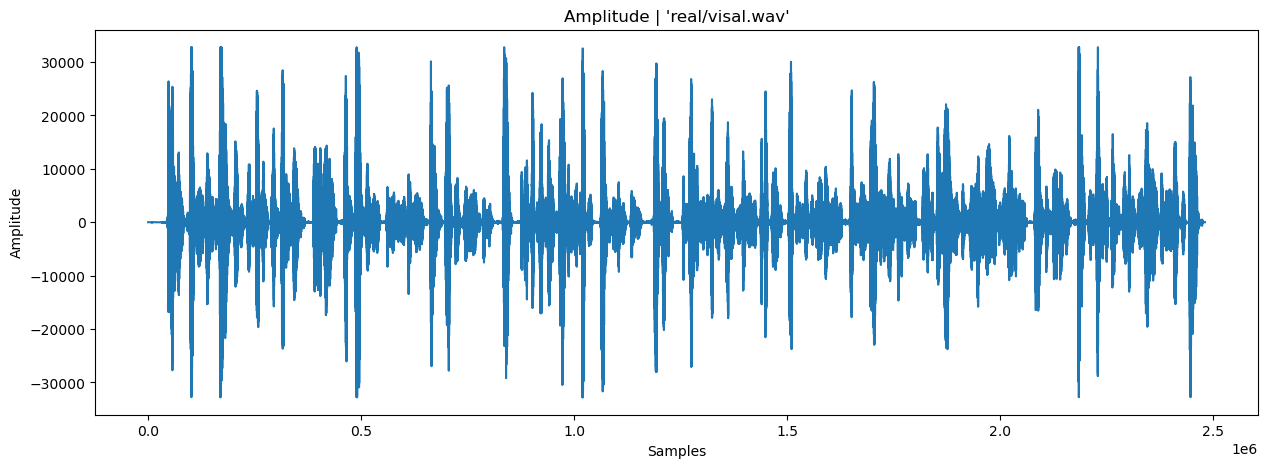

In [81]:
plot_amplitude(r"real/visal.wav")
plt.savefig(r"rvc/amp_vis.png")
plt.show()

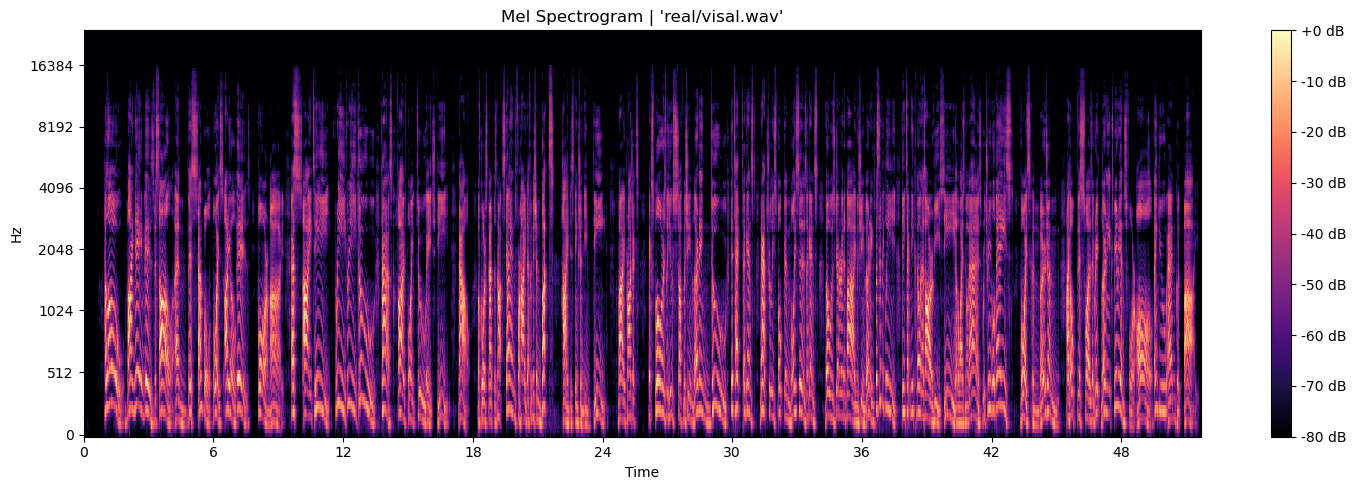

In [82]:
plot_melspec(r"real/visal.wav")
plt.savefig(r"rvc/melspec_vis.png")
plt.show()

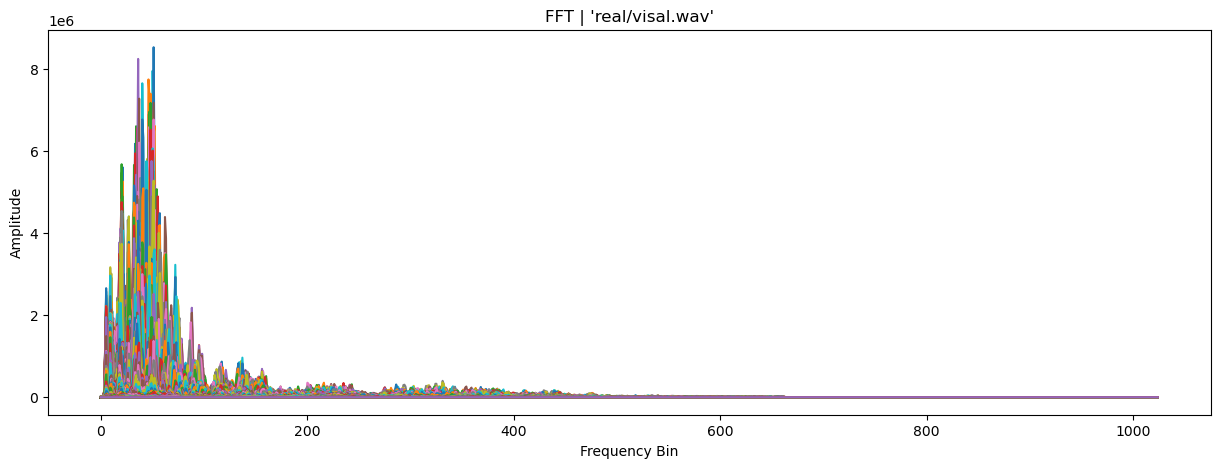

In [83]:
plot_fft(r"real/visal.wav")
plt.savefig(r"rvc/fft_vis.png")
plt.show()

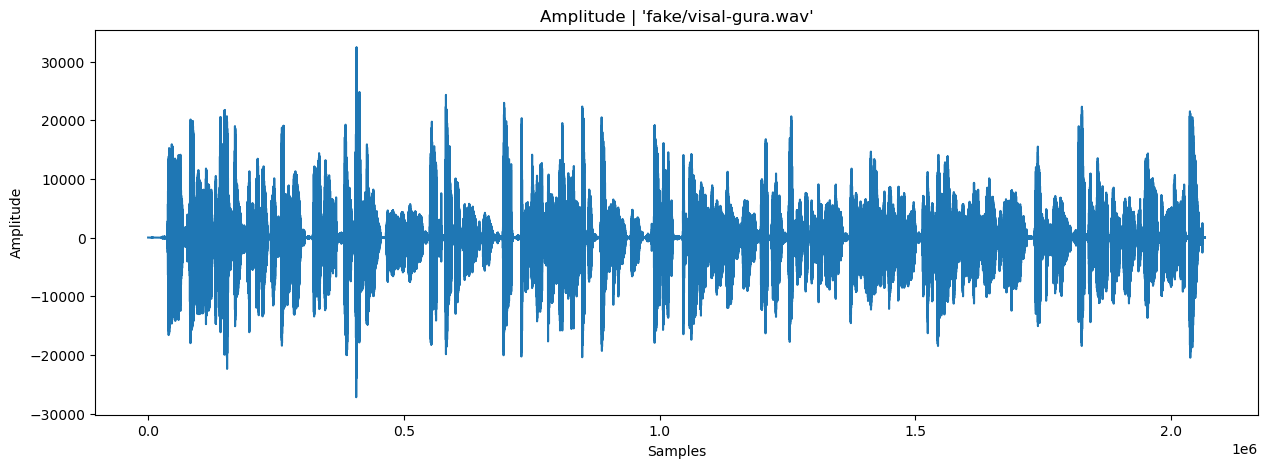

In [84]:
plot_amplitude(r"fake/visal-gura.wav")
plt.savefig(r"rvc/amp_vis_gura.png")
plt.show()

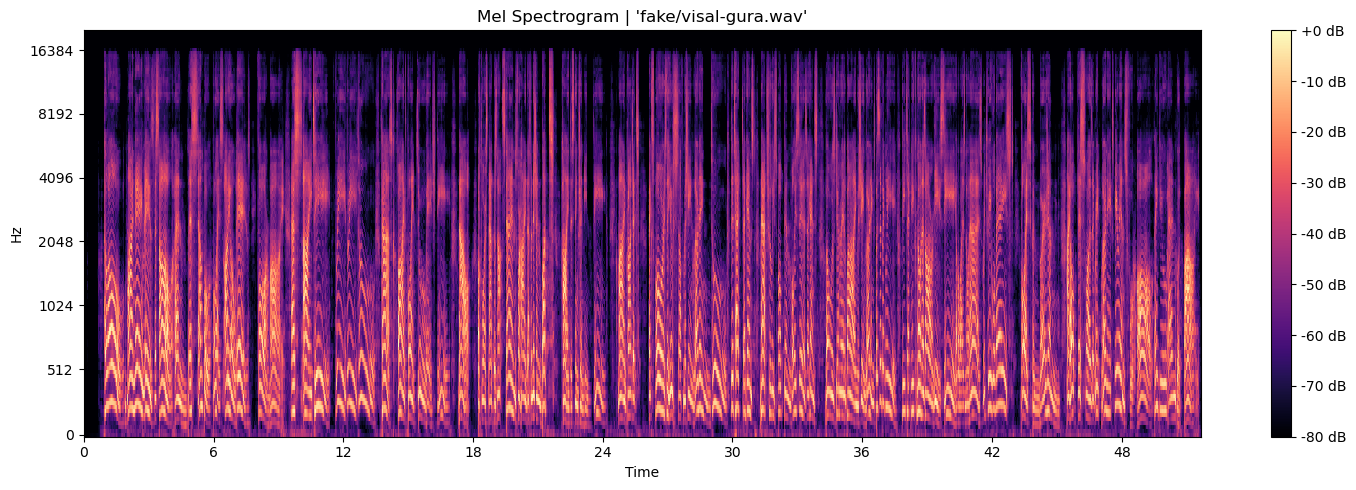

In [85]:
plot_melspec(r"fake/visal-gura.wav")
plt.savefig(r"rvc/melspec_vis_gura.png")
plt.show()

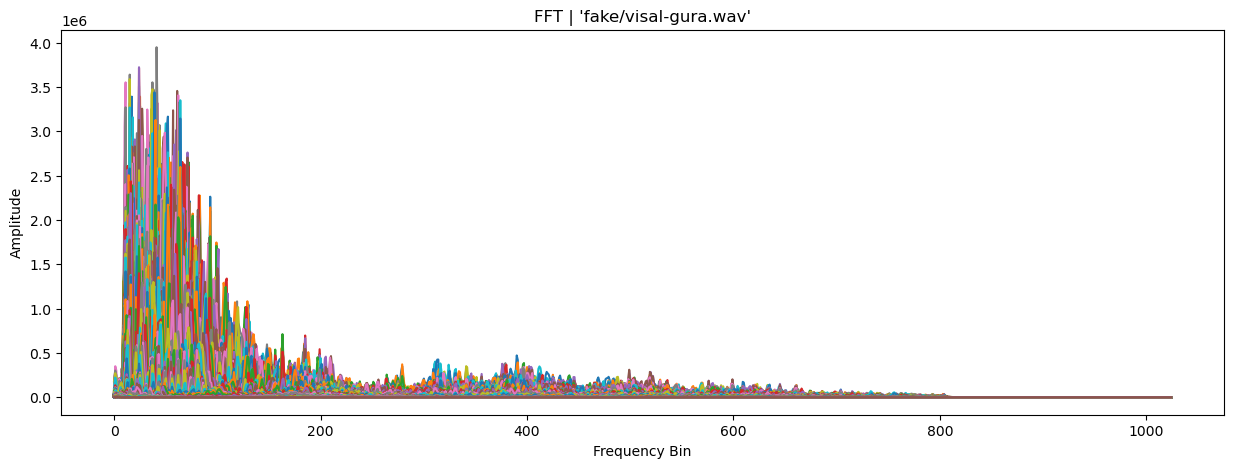

In [86]:
plot_fft(r"fake/visal-gura.wav")
plt.savefig(r"rvc/fft_vis_gura.png")
plt.show()

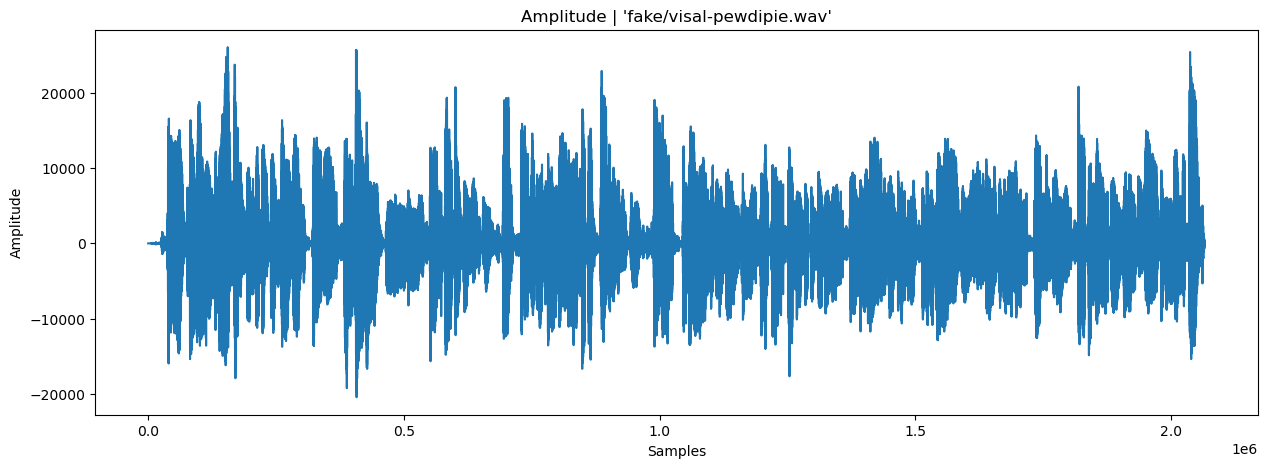

In [87]:
plot_amplitude(r"fake/visal-pewdipie.wav")
plt.savefig(r"rvc/amp_vis_pewds.png")
plt.show()

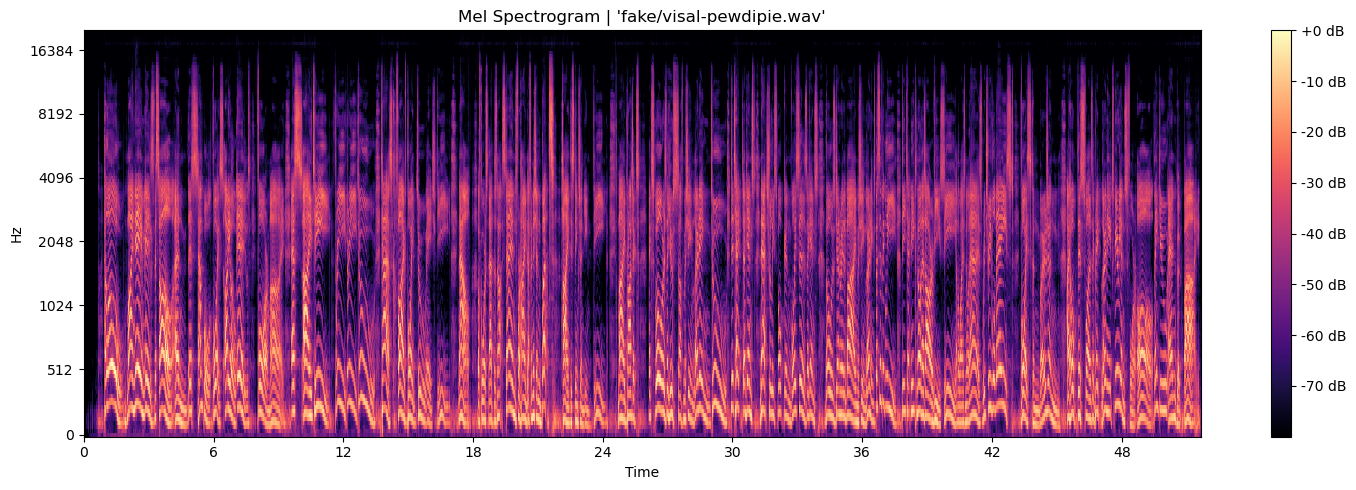

In [88]:
plot_melspec(r"fake/visal-pewdipie.wav")
plt.savefig(r"rvc/melspec_vis_pewds.png")
plt.show()

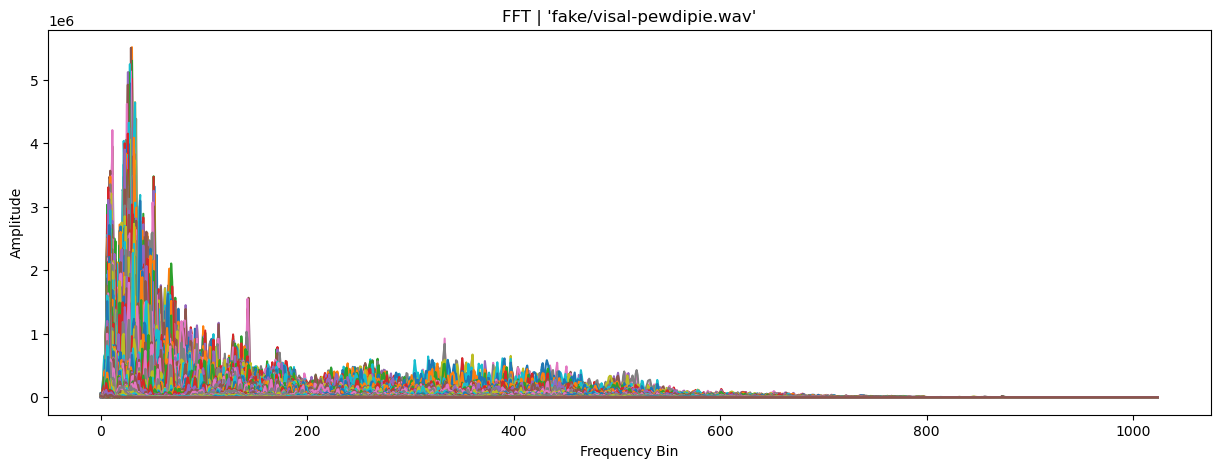

In [89]:
plot_fft(r"fake/visal-pewdipie.wav")
plt.savefig(r"rvc/fft_vis_pewds.png")
plt.show()

### Experiments

In [6]:
get_features_row(r"real\gura-original.wav", "REAL")

NameError: name 'get_features_row' is not defined

#### Dataset Creation

In [381]:
df_list = []

# Real
for dirpath, dirnames, filenames in os.walk(r"C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real"):
    for f in filenames:
        if f.lower().endswith(".wav"):  # only WAV files
            full_path = os.path.join(dirpath, f)
            df_list.append(get_features_row(full_path, "REAL"))
# Fake 
for dirpath, dirnames, filenames in os.walk(r"E:\332\fake"):
    for f in filenames:
        if f.lower().endswith(".wav"):  # only WAV files
            full_path = os.path.join(dirpath, f)
            df_list.append(get_features_row(full_path, "FAKE"))

# Create dataset
dataset = pd.concat(df_list, ignore_index=True)

<==== Current audio: C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\ariana-original.wav [REAL] ====>
sr:  44100
Audio length: 261.43 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\ariana-original.wav: Success! Average processing time (1 second blocks): 0.058s (58.110ms)
<==== Current audio: C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\biden-original.wav [REAL] ====>
sr:  48000
Audio length: 600.00 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\biden-original.wav: Success! Average processing time (1 second blocks): 0.070s (69.843ms)
<==== Current audio: C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\gura-original.wav [REAL] ====>
sr:  44100
Audio length: 63.67 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\gura-original.wav: Success! Average processing time (1 second blocks): 0.067s (66.869ms)
<==== Current audio: C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\ludwig-original.wav [REAL] ====>
sr:  44100
Audio length: 600.00 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\ludwig-original.wav: Success! Average processing time (1 second blocks): 0.063s (62.568ms)
<==== Current audio: C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\obama-original.wav [REAL] ====>
sr:  48000
Audio length: 600.45 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\obama-original.wav: Success! Average processing time (1 second blocks): 0.071s (71.187ms)
<==== Current audio: C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\pewdiepie-original.wav [REAL] ====>
sr:  44100
Audio length: 381.74 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\pewdiepie-original.wav: Success! Average processing time (1 second blocks): 0.066s (65.729ms)
<==== Current audio: C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\trump-original.wav [REAL] ====>
sr:  48000
Audio length: 600.43 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real\trump-original.wav: Success! Average processing time (1 second blocks): 0.072s (72.053ms)
<==== Current audio: E:\332\fake\ariana-biden.wav [FAKE] ====>
sr:  40000
Audio length: 261.40 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\ariana-biden.wav: Success! Average processing time (1 second blocks): 0.056s (55.985ms)
<==== Current audio: E:\332\fake\ariana-gura.wav [FAKE] ====>
sr:  40000
Audio length: 261.40 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\ariana-gura.wav: Success! Average processing time (1 second blocks): 0.054s (54.229ms)
<==== Current audio: E:\332\fake\ariana-ludwig.wav [FAKE] ====>
sr:  40000
Audio length: 261.40 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\ariana-ludwig.wav: Success! Average processing time (1 second blocks): 0.062s (62.264ms)
<==== Current audio: E:\332\fake\ariana-obama.wav [FAKE] ====>
sr:  40000
Audio length: 261.40 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\ariana-obama.wav: Success! Average processing time (1 second blocks): 0.061s (60.636ms)
<==== Current audio: E:\332\fake\ariana-pewdiepie.wav [FAKE] ====>
sr:  40000
Audio length: 261.40 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\ariana-pewdiepie.wav: Success! Average processing time (1 second blocks): 0.057s (56.555ms)
<==== Current audio: E:\332\fake\ariana-trump.wav [FAKE] ====>
sr:  40000
Audio length: 261.40 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\ariana-trump.wav: Success! Average processing time (1 second blocks): 0.075s (75.476ms)
<==== Current audio: E:\332\fake\biden-ariana.wav [FAKE] ====>
sr:  40000
Audio length: 599.92 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\biden-ariana.wav: Success! Average processing time (1 second blocks): 0.061s (60.812ms)
<==== Current audio: E:\332\fake\biden-gura.wav [FAKE] ====>
sr:  40000
Audio length: 599.92 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\biden-gura.wav: Success! Average processing time (1 second blocks): 0.057s (57.369ms)
<==== Current audio: E:\332\fake\biden-ludwig.wav [FAKE] ====>
sr:  40000
Audio length: 599.92 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\biden-ludwig.wav: Success! Average processing time (1 second blocks): 0.058s (57.530ms)
<==== Current audio: E:\332\fake\biden-obama.wav [FAKE] ====>
sr:  40000
Audio length: 599.92 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\biden-obama.wav: Success! Average processing time (1 second blocks): 0.061s (60.732ms)
<==== Current audio: E:\332\fake\biden-pewdiepie.wav [FAKE] ====>
sr:  40000
Audio length: 599.92 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\biden-pewdiepie.wav: Success! Average processing time (1 second blocks): 0.054s (53.696ms)
<==== Current audio: E:\332\fake\biden-trump.wav [FAKE] ====>
sr:  40000
Audio length: 599.92 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\biden-trump.wav: Success! Average processing time (1 second blocks): 0.057s (57.432ms)
<==== Current audio: E:\332\fake\gura-ariana.wav [FAKE] ====>
sr:  40000
Audio length: 63.66 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\gura-ariana.wav: Success! Average processing time (1 second blocks): 0.053s (53.482ms)
<==== Current audio: E:\332\fake\gura-biden.wav [FAKE] ====>
sr:  40000
Audio length: 63.66 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\gura-biden.wav: Success! Average processing time (1 second blocks): 0.054s (53.899ms)
<==== Current audio: E:\332\fake\gura-ludwig.wav [FAKE] ====>
sr:  40000
Audio length: 63.66 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\gura-ludwig.wav: Success! Average processing time (1 second blocks): 0.058s (58.387ms)
<==== Current audio: E:\332\fake\gura-obama.wav [FAKE] ====>
sr:  40000
Audio length: 63.66 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\gura-obama.wav: Success! Average processing time (1 second blocks): 0.054s (54.131ms)
<==== Current audio: E:\332\fake\gura-pewdiepie.wav [FAKE] ====>
sr:  40000
Audio length: 63.66 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\gura-pewdiepie.wav: Success! Average processing time (1 second blocks): 0.056s (55.835ms)
<==== Current audio: E:\332\fake\gura-trump.wav [FAKE] ====>
sr:  40000
Audio length: 63.66 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\gura-trump.wav: Success! Average processing time (1 second blocks): 0.063s (63.085ms)
<==== Current audio: E:\332\fake\ludwig-ariana.wav [FAKE] ====>
sr:  40000
Audio length: 599.94 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\ludwig-ariana.wav: Success! Average processing time (1 second blocks): 0.058s (58.264ms)
<==== Current audio: E:\332\fake\ludwig-biden.wav [FAKE] ====>
sr:  40000
Audio length: 599.94 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\ludwig-biden.wav: Success! Average processing time (1 second blocks): 0.062s (61.885ms)
<==== Current audio: E:\332\fake\ludwig-gura.wav [FAKE] ====>
sr:  40000
Audio length: 599.94 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\ludwig-gura.wav: Success! Average processing time (1 second blocks): 0.058s (58.471ms)
<==== Current audio: E:\332\fake\ludwig-obama.wav [FAKE] ====>
sr:  40000
Audio length: 599.94 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\ludwig-obama.wav: Success! Average processing time (1 second blocks): 0.060s (60.246ms)
<==== Current audio: E:\332\fake\ludwig-pewdiepie.wav [FAKE] ====>
sr:  40000
Audio length: 599.94 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\ludwig-pewdiepie.wav: Success! Average processing time (1 second blocks): 0.060s (60.235ms)
<==== Current audio: E:\332\fake\ludwig-trump.wav [FAKE] ====>
sr:  40000
Audio length: 599.94 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\ludwig-trump.wav: Success! Average processing time (1 second blocks): 0.052s (51.748ms)
<==== Current audio: E:\332\fake\obama-ariana.wav [FAKE] ====>
sr:  40000
Audio length: 600.42 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\obama-ariana.wav: Success! Average processing time (1 second blocks): 0.057s (56.869ms)
<==== Current audio: E:\332\fake\obama-biden.wav [FAKE] ====>
sr:  40000
Audio length: 600.42 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\obama-biden.wav: Success! Average processing time (1 second blocks): 0.056s (56.398ms)
<==== Current audio: E:\332\fake\obama-gura.wav [FAKE] ====>
sr:  40000
Audio length: 600.42 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\obama-gura.wav: Success! Average processing time (1 second blocks): 0.063s (62.643ms)
<==== Current audio: E:\332\fake\obama-ludwig.wav [FAKE] ====>
sr:  40000
Audio length: 600.42 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\obama-ludwig.wav: Success! Average processing time (1 second blocks): 0.063s (62.739ms)
<==== Current audio: E:\332\fake\obama-pewdiepie.wav [FAKE] ====>
sr:  40000
Audio length: 600.42 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\obama-pewdiepie.wav: Success! Average processing time (1 second blocks): 0.057s (57.256ms)
<==== Current audio: E:\332\fake\obama-trump.wav [FAKE] ====>
sr:  40000
Audio length: 600.42 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\obama-trump.wav: Success! Average processing time (1 second blocks): 0.057s (57.355ms)
<==== Current audio: E:\332\fake\pewdiepie-ariana.wav [FAKE] ====>
sr:  40000
Audio length: 381.70 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\pewdiepie-ariana.wav: Success! Average processing time (1 second blocks): 0.056s (56.081ms)
<==== Current audio: E:\332\fake\pewdiepie-biden.wav [FAKE] ====>
sr:  40000
Audio length: 381.70 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\pewdiepie-biden.wav: Success! Average processing time (1 second blocks): 0.059s (58.844ms)
<==== Current audio: E:\332\fake\pewdiepie-gura.wav [FAKE] ====>
sr:  40000
Audio length: 381.70 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\pewdiepie-gura.wav: Success! Average processing time (1 second blocks): 0.060s (59.646ms)
<==== Current audio: E:\332\fake\pewdiepie-ludwig.wav [FAKE] ====>
sr:  40000
Audio length: 381.70 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\pewdiepie-ludwig.wav: Success! Average processing time (1 second blocks): 0.062s (61.895ms)
<==== Current audio: E:\332\fake\pewdiepie-obama.wav [FAKE] ====>
sr:  40000
Audio length: 381.70 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\pewdiepie-obama.wav: Success! Average processing time (1 second blocks): 0.060s (60.493ms)
<==== Current audio: E:\332\fake\pewdiepie-trump.wav [FAKE] ====>
sr:  40000
Audio length: 381.70 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\pewdiepie-trump.wav: Success! Average processing time (1 second blocks): 0.066s (66.206ms)
<==== Current audio: E:\332\fake\trump-ariana.wav [FAKE] ====>
sr:  40000
Audio length: 600.36 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\trump-ariana.wav: Success! Average processing time (1 second blocks): 0.057s (56.910ms)
<==== Current audio: E:\332\fake\trump-biden.wav [FAKE] ====>
sr:  40000
Audio length: 600.36 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\trump-biden.wav: Success! Average processing time (1 second blocks): 0.057s (56.831ms)
<==== Current audio: E:\332\fake\trump-gura.wav [FAKE] ====>
sr:  40000
Audio length: 600.36 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\trump-gura.wav: Success! Average processing time (1 second blocks): 0.062s (62.312ms)
<==== Current audio: E:\332\fake\trump-ludwig.wav [FAKE] ====>
sr:  40000
Audio length: 600.36 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\trump-ludwig.wav: Success! Average processing time (1 second blocks): 0.060s (60.086ms)
<==== Current audio: E:\332\fake\trump-obama.wav [FAKE] ====>
sr:  40000
Audio length: 600.36 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\trump-obama.wav: Success! Average processing time (1 second blocks): 0.062s (62.359ms)
<==== Current audio: E:\332\fake\trump-pewdiepie.wav [FAKE] ====>
sr:  40000
Audio length: 600.36 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] E:\332\fake\trump-pewdiepie.wav: Success! Average processing time (1 second blocks): 0.058s (58.103ms)


In [382]:
dataset.to_csv("my_dataset.csv")

In [389]:
dataset["LABEL"].value_counts()

LABEL
FAKE    29298
REAL     4883
Name: count, dtype: int64

In [410]:
# Prepare features and labels
# Separate majority and minority
df_majority = dataset[dataset["LABEL"] == "FAKE"]
df_minority = dataset[dataset["LABEL"] == "REAL"]

# Downsample majority to match minority
df_majority_down = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=42
)

dataset_balance = pd.concat([df_majority_down, df_minority])

In [583]:
dataset_balance.to_csv("dataset_balance_1.csv")

In [584]:
dataset_balance = pd.read_csv("DATASET-balanced.csv")

In [585]:
X = dataset_balance.drop(columns='LABEL').values
y = (dataset_balance['LABEL'] == 'FAKE').astype(int).values  # 0=REAL, 1=FAKE

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create XGBoost classifier
clf = xgb.XGBClassifier(
    n_estimators=330
)

# Train
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=kf, scoring='f1')

# Predict

# --- Measure per-sample ---
#start = time.time()
#y_pred = clf.predict(X_test)
#end = time.time()
#print(f"Inference time (1 sample): {(end - start)/len(X_test) * 1000:.3f} ms")

# Evaluate
#print("Accuracy:", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))


print("F1 scores per fold:", scores)

F1 scores per fold: [0.994132 0.996644 0.992519 0.993399 0.994123 0.992327 0.991722 0.989437
 0.993811 0.991349]


In [441]:
clf_2 = xgb.XGBClassifier(
    n_estimators=330
)

# Train
clf_2.fit(X_train, y_train)

# Predict
y_pred_2 = clf_2.predict(X_test)

In [539]:
df_demo = get_features_row(r"C:\Users\lenovo\Downloads\taylor-gura.wav", "FAKE")

<==== Current audio: C:\Users\lenovo\Downloads\taylor-gura.wav [FAKE] ====>
sr:  40000
Audio length: 600.12 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[DONE] C:\Users\lenovo\Downloads\taylor-gura.wav: Success! Average processing time (1 second blocks): 0.060s (60.462ms)


In [540]:
df_demo

chroma_stft_1  chroma_stft_2  chroma_stft_3  chroma_stft_4  \
0         0.483452       0.565062       0.889436       0.172853   
1         0.041350       0.029818       0.024093       0.056913   
2         0.019456       0.020503       0.046479       0.043451   
3         0.196508       0.349277       0.210703       0.236663   
4         0.854335       1.000000       0.717119       0.187873   
..             ...            ...            ...            ...   
938       0.047134       0.096580       0.164088       0.065902   
939       0.085206       0.033727       0.021495       0.044453   
940       0.037951       0.048465       0.044459       0.020296   
941       0.174215       0.097880       0.118993       0.358288   
942       0.555605       0.353857       0.366362       0.679543   

     chroma_stft_5  chroma_stft_6  chroma_stft_7  chroma_stft_8  \
0         0.403266       0.839600       0.147709       0.236321   
1         0.204715       0.142594       0.048751       0.072146   
2         0.043688       0.044283       0.172949       1.000000   
3         0.406451       0.162634       0.197149       0.167849   
4         0.032422       0.029685       0.080925       0.135775   
..             ...            ...            ...            ...   
938       0.202752       0.183348       0.671244       1.000000   
939       0.048381       0.326225       1.000000       0.623549   
940       0.045576       0.258428       0.821786       1.000000   
941       0.713925       1.000000       0.480232       0.105762   
942       0.629077       0.549312       1.000000       0.875994   

     chroma_stft_9  chroma_stft_10  ...    mfcc_12    mfcc_13    mfcc_14  \
0         0.282519        0.366556  ...   3.551892  10.747828  -2.721311   
1         0.535755        1.000000  ... -11.379322  -6.048292   0.044040   
2         0.273570        0.012042  ...   7.313288   1.585193  -5.203707   
3         0.437474        1.000000  ...  -2.124038  -1.450562  -1.488031   
4         0.127270        0.123026  ... -22.368677 -19.883595  -0.507727   
..             ...             ...  ...        ...        ...        ...   
938       0.473724        0.087873  ...  -0.303408  -0.802257 -10.956432   
939       0.745877        0.119117  ...  -6.726419  -8.380102 -12.749428   
940       0.178487        0.029599  ...   7.940698  -2.446647 -11.107082   
941       0.077739        0.056664  ...  -3.707317 -12.106457 -19.292961   
942       0.504300        0.398326  ...  -7.673109  -0.646765   6.398402   

       mfcc_15    mfcc_16    mfcc_17    mfcc_18    mfcc_19    mfcc_20  LABEL  
0    -9.831317 -10.447218  -6.010508  -6.550797 -13.140589   5.968361   FAKE  
1   -16.899702  -6.618083  -6.902161 -11.676984 -14.425173  -4.833264   FAKE  
2   -13.643012  -7.362577  -0.106548  -5.899809   0.669717  -2.794263   FAKE  
3    -5.552127   2.811491  -8.810437   1.869793  -9.495073   6.025336   FAKE  
4   -11.398623  -8.414040  -7.735775  -8.129625  -7.096194  -6.982613   FAKE  
..         ...        ...        ...        ...        ...        ...    ...  
938  -9.737782   1.512990  -0.590999  -3.614177  -8.537829  -1.088573   FAKE  
939  -1.771662   0.398321 -14.157316 -13.887441  -5.561314  -3.371812   FAKE  
940 -11.205965   8.932909   7.609635  -5.207794 -13.378178  -3.117587   FAKE  
941 -12.775558  -3.340956  -2.418992  -8.569896  -9.161482  -5.953052   FAKE  
942  -7.599546  -3.941683  -3.795813   4.247923   1.130771  10.420107   FAKE  

[943 rows x 38 columns]

In [541]:
XX = df_demo.drop(columns='LABEL').values
yy = (df_demo['LABEL'] == 'FAKE').astype(int).values  # 0=REAL, 1=FAK

In [542]:
start = time.time()
y_preds2 = clf_2.predict(XX)
end = time.time()
print(f"Inference time (1 sample): {(end - start)/len(yy) * 1000:.3f} ms")
#0.004 -> 0.047

Inference time (1 sample): 0.008 ms


In [543]:
y_preds2
values, counts = np.unique(y_preds2, return_counts=True)
percentages = counts / len(y_preds2) * 100

for v, p in zip(values, percentages):
    class_name = "REAL" if v == 0 else "FAKE"
    print(f"{class_name} [{v}]: {p:.2f}%")

REAL [0]: 3.18%
FAKE [1]: 96.82%


In [544]:
print("Accuracy:", accuracy_score(y_preds2, yy))

Accuracy: 0.968186638388123


#### Dataset v2

In [219]:
df2 = create_dataset(0.33)
df2.to_csv("my_dataset_2.csv")
df2_balanced = balance_df(df2)
df2_balanced.to_csv("dataset_balanced_2.csv")

<==== Current audio: ariana-original.wav [REAL] ====>
sr:  44100
Audio length: 261.43 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=14554 is too large for input signal of length=14553
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ariana-original.wav: Success! Average processing time (1 second blocks): 0.279s (279.493ms)
<==== Current audio: biden-original.wav [REAL] ====>
sr:  48000
Audio length: 600.00 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=15841 is too large for input signal of length=15840
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> biden-original.wav: Success! Average processing time (1 second blocks): 0.239s (239.472ms)
<==== Current audio: gura-original.wav [REAL] ====>
sr:  44100
Audio length: 63.67 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=14554 is too large for input signal of length=14553
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> gura-original.wav: Success! Average processing time (1 second blocks): 0.272s (271.508ms)
<==== Current audio: ludwig-original.wav [REAL] ====>
sr:  44100
Audio length: 600.00 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=14554 is too large for input signal of length=14553
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ludwig-original.wav: Success! Average processing time (1 second blocks): 0.295s (295.157ms)
<==== Current audio: obama-original.wav [REAL] ====>
sr:  48000
Audio length: 600.45 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=15841 is too large for input signal of length=15840
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> obama-original.wav: Success! Average processing time (1 second blocks): 0.198s (197.683ms)
<==== Current audio: pewdiepie-original.wav [REAL] ====>
sr:  44100
Audio length: 381.74 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=14554 is too large for input signal of length=14553
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> pewdiepie-original.wav: Success! Average processing time (1 second blocks): 0.217s (216.940ms)
<==== Current audio: trump-original.wav [REAL] ====>
sr:  48000
Audio length: 600.43 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=15841 is too large for input signal of length=15840
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> trump-original.wav: Success! Average processing time (1 second blocks): 0.176s (176.223ms)
<==== Current audio: visal.wav [REAL] ====>
sr:  48000
Audio length: 51.67 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=15841 is too large for input signal of length=15840
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> visal.wav: Success! Average processing time (1 second blocks): 0.170s (169.883ms)
<==== Current audio: ariana-biden.wav [FAKE] ====>
sr:  40000
Audio length: 261.40 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ariana-biden.wav: Success! Average processing time (1 second blocks): 0.163s (163.109ms)
<==== Current audio: ariana-gura.wav [FAKE] ====>
sr:  40000
Audio length: 261.40 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ariana-gura.wav: Success! Average processing time (1 second blocks): 0.173s (173.191ms)
<==== Current audio: ariana-ludwig.wav [FAKE] ====>
sr:  40000
Audio length: 261.40 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ariana-ludwig.wav: Success! Average processing time (1 second blocks): 0.163s (163.031ms)
<==== Current audio: ariana-obama.wav [FAKE] ====>
sr:  40000
Audio length: 261.40 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ariana-obama.wav: Success! Average processing time (1 second blocks): 0.162s (162.138ms)
<==== Current audio: ariana-pewdiepie.wav [FAKE] ====>
sr:  40000
Audio length: 261.40 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ariana-pewdiepie.wav: Success! Average processing time (1 second blocks): 0.166s (165.626ms)
<==== Current audio: ariana-trump.wav [FAKE] ====>
sr:  40000
Audio length: 261.40 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ariana-trump.wav: Success! Average processing time (1 second blocks): 0.160s (159.675ms)
<==== Current audio: biden-ariana.wav [FAKE] ====>
sr:  40000
Audio length: 599.92 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> biden-ariana.wav: Success! Average processing time (1 second blocks): 0.160s (160.204ms)
<==== Current audio: biden-gura.wav [FAKE] ====>
sr:  40000
Audio length: 599.92 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> biden-gura.wav: Success! Average processing time (1 second blocks): 0.158s (158.461ms)
<==== Current audio: biden-ludwig.wav [FAKE] ====>
sr:  40000
Audio length: 599.92 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> biden-ludwig.wav: Success! Average processing time (1 second blocks): 0.164s (163.518ms)
<==== Current audio: biden-obama.wav [FAKE] ====>
sr:  40000
Audio length: 599.92 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> biden-obama.wav: Success! Average processing time (1 second blocks): 0.156s (156.233ms)
<==== Current audio: biden-pewdiepie.wav [FAKE] ====>
sr:  40000
Audio length: 599.92 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> biden-pewdiepie.wav: Success! Average processing time (1 second blocks): 0.159s (159.105ms)
<==== Current audio: biden-trump.wav [FAKE] ====>
sr:  40000
Audio length: 599.92 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> biden-trump.wav: Success! Average processing time (1 second blocks): 0.161s (160.757ms)
<==== Current audio: gura-ariana.wav [FAKE] ====>
sr:  40000
Audio length: 63.66 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> gura-ariana.wav: Success! Average processing time (1 second blocks): 0.155s (155.082ms)
<==== Current audio: gura-biden.wav [FAKE] ====>
sr:  40000
Audio length: 63.66 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> gura-biden.wav: Success! Average processing time (1 second blocks): 0.158s (158.499ms)
<==== Current audio: gura-ludwig.wav [FAKE] ====>
sr:  40000
Audio length: 63.66 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> gura-ludwig.wav: Success! Average processing time (1 second blocks): 0.164s (164.187ms)
<==== Current audio: gura-obama.wav [FAKE] ====>
sr:  40000
Audio length: 63.66 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> gura-obama.wav: Success! Average processing time (1 second blocks): 0.156s (155.704ms)
<==== Current audio: gura-pewdiepie.wav [FAKE] ====>
sr:  40000
Audio length: 63.66 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> gura-pewdiepie.wav: Success! Average processing time (1 second blocks): 0.167s (166.690ms)
<==== Current audio: gura-trump.wav [FAKE] ====>
sr:  40000
Audio length: 63.66 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> gura-trump.wav: Success! Average processing time (1 second blocks): 0.154s (153.517ms)
<==== Current audio: ludwig-ariana.wav [FAKE] ====>
sr:  40000
Audio length: 599.94 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ludwig-ariana.wav: Success! Average processing time (1 second blocks): 0.160s (160.027ms)
<==== Current audio: ludwig-biden.wav [FAKE] ====>
sr:  40000
Audio length: 599.94 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ludwig-biden.wav: Success! Average processing time (1 second blocks): 0.159s (158.891ms)
<==== Current audio: ludwig-gura.wav [FAKE] ====>
sr:  40000
Audio length: 599.94 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ludwig-gura.wav: Success! Average processing time (1 second blocks): 0.158s (158.166ms)
<==== Current audio: ludwig-obama.wav [FAKE] ====>
sr:  40000
Audio length: 599.94 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ludwig-obama.wav: Success! Average processing time (1 second blocks): 0.159s (159.203ms)
<==== Current audio: ludwig-pewdiepie.wav [FAKE] ====>
sr:  40000
Audio length: 599.94 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ludwig-pewdiepie.wav: Success! Average processing time (1 second blocks): 0.165s (164.796ms)
<==== Current audio: ludwig-trump.wav [FAKE] ====>
sr:  40000
Audio length: 599.94 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> ludwig-trump.wav: Success! Average processing time (1 second blocks): 0.161s (160.685ms)
<==== Current audio: obama-ariana.wav [FAKE] ====>
sr:  40000
Audio length: 600.42 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> obama-ariana.wav: Success! Average processing time (1 second blocks): 0.157s (157.220ms)
<==== Current audio: obama-biden.wav [FAKE] ====>
sr:  40000
Audio length: 600.42 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> obama-biden.wav: Success! Average processing time (1 second blocks): 0.158s (158.210ms)
<==== Current audio: obama-gura.wav [FAKE] ====>
sr:  40000
Audio length: 600.42 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> obama-gura.wav: Success! Average processing time (1 second blocks): 0.172s (172.190ms)
<==== Current audio: obama-ludwig.wav [FAKE] ====>
sr:  40000
Audio length: 600.42 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> obama-ludwig.wav: Success! Average processing time (1 second blocks): 0.168s (168.093ms)
<==== Current audio: obama-pewdiepie.wav [FAKE] ====>
sr:  40000
Audio length: 600.42 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> obama-pewdiepie.wav: Success! Average processing time (1 second blocks): 0.167s (167.285ms)
<==== Current audio: obama-trump.wav [FAKE] ====>
sr:  40000
Audio length: 600.42 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> obama-trump.wav: Success! Average processing time (1 second blocks): 0.161s (160.976ms)
<==== Current audio: pewdiepie-ariana.wav [FAKE] ====>
sr:  40000
Audio length: 381.70 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> pewdiepie-ariana.wav: Success! Average processing time (1 second blocks): 0.161s (161.002ms)
<==== Current audio: pewdiepie-biden.wav [FAKE] ====>
sr:  40000
Audio length: 381.70 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> pewdiepie-biden.wav: Success! Average processing time (1 second blocks): 0.162s (161.964ms)
<==== Current audio: pewdiepie-gura.wav [FAKE] ====>
sr:  40000
Audio length: 381.70 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> pewdiepie-gura.wav: Success! Average processing time (1 second blocks): 0.162s (161.932ms)
<==== Current audio: pewdiepie-ludwig.wav [FAKE] ====>
sr:  40000
Audio length: 381.70 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> pewdiepie-ludwig.wav: Success! Average processing time (1 second blocks): 0.161s (161.434ms)
<==== Current audio: pewdiepie-obama.wav [FAKE] ====>
sr:  40000
Audio length: 381.70 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> pewdiepie-obama.wav: Success! Average processing time (1 second blocks): 0.154s (154.297ms)
<==== Current audio: pewdiepie-trump.wav [FAKE] ====>
sr:  40000
Audio length: 381.70 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> pewdiepie-trump.wav: Success! Average processing time (1 second blocks): 0.153s (153.046ms)
<==== Current audio: trump-ariana.wav [FAKE] ====>
sr:  40000
Audio length: 600.36 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> trump-ariana.wav: Success! Average processing time (1 second blocks): 0.155s (155.093ms)
<==== Current audio: trump-biden.wav [FAKE] ====>
sr:  40000
Audio length: 600.36 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> trump-biden.wav: Success! Average processing time (1 second blocks): 0.155s (154.616ms)
<==== Current audio: trump-gura.wav [FAKE] ====>
sr:  40000
Audio length: 600.36 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> trump-gura.wav: Success! Average processing time (1 second blocks): 0.161s (160.620ms)
<==== Current audio: trump-ludwig.wav [FAKE] ====>
sr:  40000
Audio length: 600.36 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> trump-ludwig.wav: Success! Average processing time (1 second blocks): 0.162s (162.190ms)
<==== Current audio: trump-obama.wav [FAKE] ====>
sr:  40000
Audio length: 600.36 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> trump-obama.wav: Success! Average processing time (1 second blocks): 0.163s (163.481ms)
<==== Current audio: trump-pewdiepie.wav [FAKE] ====>
sr:  40000
Audio length: 600.36 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=13201 is too large for input signal of length=13200
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> trump-pewdiepie.wav: Success! Average processing time (1 second blocks): 0.153s (152.865ms)


In [230]:
df2_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18936 entries, 0 to 18935
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   chroma_stft_1   18936 non-null  float64
 1   chroma_stft_2   18936 non-null  float64
 2   chroma_stft_3   18936 non-null  float64
 3   chroma_stft_4   18936 non-null  float64
 4   chroma_stft_5   18936 non-null  float64
 5   chroma_stft_6   18936 non-null  float64
 6   chroma_stft_7   18936 non-null  float64
 7   chroma_stft_8   18936 non-null  float64
 8   chroma_stft_9   18936 non-null  float64
 9   chroma_stft_10  18936 non-null  float64
 10  chroma_stft_11  18936 non-null  float64
 11  chroma_stft_12  18936 non-null  float64
 12  rms             18936 non-null  float64
 13  spec_cent       18936 non-null  float64
 14  spec_bw         18936 non-null  float64
 15  rolloff         18936 non-null  float64
 16  zcr             18936 non-null  float64
 17  mfcc_1          18936 non-null 

In [228]:
X2 = df2_balanced.drop(columns='LABEL').values
y2 = (df2_balanced['LABEL'] == 'FAKE').astype(int).values 

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

clf_xgb2 = xgb.XGBClassifier(n_estimators=250, learning_rate=0.01, max_depth=10)
clf_xgb2.fit(X2_train, y2_train)
get_basic_metrics(clf_xgb2, X2_test, y2_test)

Average inference time (1s): 0.006 ms
Accuracy: 0.911459250132019
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2841
           1       0.91      0.92      0.91      2840

    accuracy                           0.91      5681
   macro avg       0.91      0.91      0.91      5681
weighted avg       0.91      0.91      0.91      5681



In [294]:
df_demo2 = get_features_row(r"C:\Users\lenovo\Downloads\taylor-original.wav", "REAL", 0.33)

<==== Current audio: taylor-original.wav [REAL] ====>
sr:  44100
Audio length: 600.18 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=14554 is too large for input signal of length=14553
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> taylor-original.wav: Success! Average processing time (1 second blocks): 0.230s (230.335ms)


In [295]:
Xdemo = df_demo2.drop(columns='LABEL').values
ydemo = (df_demo2['LABEL'] == 'FAKE').astype(int).values  # 0=REAL, 1=FAK

start = time.time()
y_preds2 = clf_xgb2.predict(Xdemo)
end = time.time()
print(f"Inference time (1 sample): {(end - start)/len(ydemo) * 1000:.3f} ms")
#0.004 -> 0.047

values, counts = np.unique(y_preds2, return_counts=True)
percentages = counts / len(y_preds2) * 100

for v, p in zip(values, percentages):
    class_name = "REAL" if v == 0 else "FAKE"
    print(f"{class_name} [{v}]: {p:.2f}%")

print("Accuracy:", accuracy_score(y_preds2, ydemo))

Inference time (1 sample): 0.018 ms
REAL [0]: 10.61%
FAKE [1]: 89.39%
Accuracy: 0.10611111111111111


In [296]:
pred_one_sec = []
for i in range(0, len(y_preds2), 3):   # step by 3
    one_sec_blocks = [y_preds2[i], y_preds2[i+1], y_preds2[i+2]]
    pred_one_sec.append(np.max(one_sec_blocks)) 

In [297]:
values, counts = np.unique(pred_one_sec, return_counts=True)
percentages = counts / len(pred_one_sec) * 100

for v, p in zip(values, percentages):
    class_name = "REAL" if v == 0 else "FAKE"
    print(f"{class_name} [{v}]: {p:.2f}%")

FAKE [1]: 100.00%


In [316]:
frame_length_sec = 1
df_list = []
new = ["taylor", "musk", "michael"]

# Real
for dirpath, dirnames, filenames in os.walk(r"C:\Users\lenovo\Documents\Deakin Units S334\SIT_332_Computer_Vision\5.2HD\real"):
    for f in filenames:
        if f.lower().endswith(".wav") and any(name in f.lower() for name in new):  # only WAV files
            full_path = os.path.join(dirpath, f)
            df_list.append(get_features_row(full_path, "REAL", frame_length_sec))
# Fake 
for dirpath, dirnames, filenames in os.walk(r"E:\332\fake"):
    for f in filenames:
        if f.lower().endswith(".wav") and any(name in f.lower() for name in new):  # only WAV files
            full_path = os.path.join(dirpath, f)
            df_list.append(get_features_row(full_path, "FAKE", frame_length_sec))

# Create dataset
dataset = pd.concat(df_list, ignore_index=True)

<==== Current audio: michael-original.wav [REAL] ====>
sr:  44100
Audio length: 191.61 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=44102 is too large for input signal of length=44100
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> michael-original.wav: Success! Average processing time (1 second blocks): 0.097s (97.330ms)
<==== Current audio: musk-original.wav [REAL] ====>
sr:  44100
Audio length: 600.13 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=44102 is too large for input signal of length=44100
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> musk-original.wav: Success! Average processing time (1 second blocks): 0.091s (91.274ms)
<==== Current audio: taylor-original.wav [REAL] ====>
sr:  44100
Audio length: 600.18 seconds


C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=44102 is too large for input signal of length=44100
  warnings.warn(
C:\Users\lenovo\anaconda3_\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


==> taylor-original.wav: Success! Average processing time (1 second blocks): 0.090s (89.707ms)


In [317]:
dataset.to_csv("new_delete_me.csv")

In [318]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2186 entries, 0 to 2185
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   chroma_stft_1   2186 non-null   float64
 1   chroma_stft_2   2186 non-null   float64
 2   chroma_stft_3   2186 non-null   float64
 3   chroma_stft_4   2186 non-null   float64
 4   chroma_stft_5   2186 non-null   float64
 5   chroma_stft_6   2186 non-null   float64
 6   chroma_stft_7   2186 non-null   float64
 7   chroma_stft_8   2186 non-null   float64
 8   chroma_stft_9   2186 non-null   float64
 9   chroma_stft_10  2186 non-null   float64
 10  chroma_stft_11  2186 non-null   float64
 11  chroma_stft_12  2186 non-null   float64
 12  rms             2186 non-null   float64
 13  spec_cent       2186 non-null   float64
 14  spec_bw         2186 non-null   float64
 15  rolloff         2186 non-null   float64
 16  zcr             2186 non-null   float64
 17  mfcc_1          2186 non-null   f

In [322]:
print(dataset["LABEL"].value_counts())

LABEL
REAL    2186
Name: count, dtype: int64


In [320]:
df1 = pd.read_csv("my_dataset.csv")

In [321]:
print(df1["LABEL"].value_counts())

LABEL
FAKE    29298
REAL     4883
Name: count, dtype: int64


In [323]:
dataset_full = pd.concat([df1, dataset], axis=0).reset_index()

In [324]:
dataset_full

index  Unnamed: 0  chroma_stft_1  chroma_stft_2  chroma_stft_3  \
0          0         0.0       0.549377       0.577754       0.467097   
1          1         1.0       0.035901       0.025161       0.022325   
2          2         2.0       0.093415       0.081286       0.170346   
3          3         3.0       0.690230       0.534576       0.354625   
4          4         4.0       0.209761       0.625001       0.705817   
...      ...         ...            ...            ...            ...   
36362   2181         NaN       0.276514       0.136797       0.152557   
36363   2182         NaN       0.054321       0.209313       0.182758   
36364   2183         NaN       0.650096       0.252178       0.106281   
36365   2184         NaN       0.553911       0.898567       0.697684   
36366   2185         NaN       0.654675       0.913179       0.856544   

       chroma_stft_4  chroma_stft_5  chroma_stft_6  chroma_stft_7  \
0           0.336206       0.329890       0.401931       0.473303   
1           0.018161       0.121382       0.167928       0.020670   
2           0.467037       0.640005       1.000000       0.403185   
3           0.725988       1.000000       0.812954       0.372207   
4           1.000000       0.711701       0.301707       0.678212   
...              ...            ...            ...            ...   
36362       0.210157       0.353156       1.000000       0.763184   
36363       0.084422       0.377679       0.394536       1.000000   
36364       0.204532       0.326948       1.000000       0.685679   
36365       0.489156       0.328029       0.182613       0.242597   
36366       1.000000       0.917594       0.776825       0.622550   

       chroma_stft_8  chroma_stft_9  chroma_stft_10  chroma_stft_11  \
0           0.539785       0.460768        0.490663        0.497072   
1           0.042659       0.099228        0.934152        1.000000   
2           0.097468       0.099303        0.251557        0.165162   
3           0.454875       0.510369        0.478715        0.359342   
4           0.266783       0.291804        0.349810        0.461036   
...              ...            ...             ...             ...   
36362       0.222761       0.227066        0.259242        0.074845   
36363       0.608275       0.184633        0.094140        0.412545   
36364       0.440514       0.356607        0.232507        0.240480   
36365       0.284316       0.456755        0.868415        1.000000   
36366       0.611285       0.781365        0.746845        0.666827   

       chroma_stft_12       rms    spec_cent      spec_bw      rolloff  \
0            1.000000  0.000000  1267.834415  1218.271579  2185.000000   
1            0.160721  0.052004  1407.096695  1746.535551  2190.500000   
2            0.111721  0.032354  1116.666774  1236.121958  1948.000000   
3            0.391359  0.010710  1387.299049  1421.107645  2493.000000   
4            0.295858  0.033860  1147.291791  1413.473474  1935.500000   
...               ...       ...          ...          ...          ...   
36362        0.183981  0.003244  1369.725801  1794.091769  2773.374223   
36363        0.199893  0.028860  1652.312180  1862.252681  3512.340710   
36364        0.417433  0.001412  2368.305951  1944.662355  4365.302027   
36365        0.609909  0.003133  2004.107763  1957.796356  4106.313773   
36366        0.731242  0.001310  3372.456433  2547.811163  6497.705319   

            zcr      mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5  \
0      0.030612  -41.529160  208.349686 -84.852737  35.651299 -54.427574   
1      0.025646   50.891544  144.116272 -32.611511 -15.594831 -25.028326   
2      0.026735    3.204695  186.963791 -58.812332  15.289454 -35.460426   
3      0.037937    2.197302  186.367905 -75.345169  35.131699 -66.301613   
4      0.032132    0.432859  175.127411 -36.639999   3.892629 -20.302677   
...         ...         ...         ...        ...        ...        ...   
36362  0.027504  -19.851208

In [325]:
print(dataset_full["LABEL"].value_counts())

LABEL
FAKE    29298
REAL     7069
Name: count, dtype: int64


In [348]:
dataset_full_balanced = balance_df(dataset_full).drop(columns=['index', 'Unnamed: 0'])

In [349]:
dataset_full_balanced

chroma_stft_1  chroma_stft_2  chroma_stft_3  chroma_stft_4  \
0           0.996099       1.000000       0.668243       0.627178   
1           0.289238       0.464180       0.844005       0.736179   
2           0.530231       0.205782       0.225617       0.154427   
3           0.794635       0.645277       0.708530       0.659428   
4           0.334195       0.196815       0.308572       0.355203   
...              ...            ...            ...            ...   
14133       0.276514       0.136797       0.152557       0.210157   
14134       0.054321       0.209313       0.182758       0.084422   
14135       0.650096       0.252178       0.106281       0.204532   
14136       0.553911       0.898567       0.697684       0.489156   
14137       0.654675       0.913179       0.856544       1.000000   

       chroma_stft_5  chroma_stft_6  chroma_stft_7  chroma_stft_8  \
0           0.795229       0.617621       0.451576       0.422399   
1           1.000000       0.759958       0.335239       0.305285   
2           0.127415       0.205170       0.129216       0.077442   
3           0.943173       1.000000       0.564239       0.294279   
4           0.376575       1.000000       0.213205       0.059496   
...              ...            ...            ...            ...   
14133       0.353156       1.000000       0.763184       0.222761   
14134       0.377679       0.394536       1.000000       0.608275   
14135       0.326948       1.000000       0.685679       0.440514   
14136       0.328029       0.182613       0.242597       0.284316   
14137       0.917594       0.776825       0.622550       0.611285   

       chroma_stft_9  chroma_stft_10  chroma_stft_11  chroma_stft_12  \
0           0.284201        0.279558        0.350969        0.470083   
1           0.217228        0.217246        0.364880        0.275293   
2           0.102019        0.195575        0.393611        1.000000   
3           0.169671        0.236229        0.276852        0.672393   
4           0.062110        0.074700        0.050840        0.138631   
...              ...             ...             ...             ...   
14133       0.227066        0.259242        0.074845        0.183981   
14134       0.184633        0.094140        0.412545        0.199893   
14135       0.356607        0.232507        0.240480        0.417433   
14136       0.456755        0.868415        1.000000        0.609909   
14137       0.781365        0.746845        0.666827        0.731242   

            rms    spec_cent      spec_bw      rolloff       zcr      mfcc_1  \
0      0.004535  1967.384461  2002.004625  4217.062500  0.045525  -64.129990   
1      0.003522  1223.038082  1695.877987  2147.670000  0.037175  -95.422035   
2      0.037191  2386.988705  1769.745662  4207.140000  0.074350   19.986828   
3      0.053486  2691.214769  1733.058740  4604.040000  0.110300  153.797470   
4      0.003598  2486.435346  2190.333849  4851.000000  0.017550 -130.881699   
...         ...          ...          ...          ...       ...         ...   
14133  0.003244  1369.725801  1794.091769  2773.374223  0.027504  -19.851208   
14134  0.028860  1652.312180  1862.252681  3512.340710  0.042991    9.150717   
14135  0.001412  2368.305951  1944.662355  4365.302027  0.072491  -16.617069   
14136  0.003133  2004.107763  1957.796356  4106.313773  0.062242   -4.405774   
14137  0.001310  3372.456433  2547.811163  6497.705319  0.128135 -162.393036   

           mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6     mfcc_7  \
0      101.126785 -42.528553  53.344894   6.179201  43.580223  19.936642   
1      154.242950 -16.753067   9.848974  -1.355270  22.449993  -1.950959   
2      104.482330 -65.392570  87.740891 -21.897411  10.632298   1.278986   
3       71.500626 -85.388184  49.422577 -13.334240  29.308296   0.234914   
4       80.647293 -14.090109  91.122452  -4.213405  12.044609 -33.589359   
...           ...        ...        ...        ...        ...      

In [350]:
print(dataset_full_balanced["LABEL"].value_counts())

LABEL
FAKE    7069
REAL    7069
Name: count, dtype: int64


In [351]:
dataset_full_balanced.to_csv("dataset_full_balanced.csv")